In [1]:
# the building we want to run
building_id = 3
# Price of the panel
price = 106
# this will create a folder which will save the files
iteration = 40
# optimization method
# Currently implemented are: rbf-net, rbf-cost, ga-50, ga-20
opt_method = "rbf-cost"
# Number of evaluations:
number_of_opt_evaluations = 100
# number of run
run_i=2
# Some cluster solution
base_path=""

In [2]:
# Parameters
opt_method = "rbf-cost"
number_of_opt_evaluations = 200
run_i = 6
iteration = 70
building_id = 2
price = 106


In [3]:
# Important file names 
# This is where the optimal solution or final population of solutions is provided
ga_file = f"{number_of_opt_evaluations}_{price}_{opt_method}_{building_id}_{run_i}.xlsx"
# here we store every run that optmizer runs
ga_proc = f"{number_of_opt_evaluations}_archived_{price}_{opt_method}_{building_id}_{run_i}.xlsx"
# Here we combine the optimal solution with the addition information that we are interested in.
ga_fina = f"{number_of_opt_evaluations}_processed_{price}_{opt_method}_{building_id}_{run_i}.xlsx"

In [4]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = base_path+'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = base_path+'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)
ga_file=ga_output_dir+ga_file
ga_proc=ga_output_dir+ga_proc
ga_fina=ga_output_dir+ga_fina



# Weather file
epw_file   = base_path+'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = base_path+'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [5]:
########### OUTPUT FILES ###############
import os
import time
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    try:
      if not os.path.exists(directory):
          os.makedirs(directory)
    except:
      time.sleep(10)
      if not os.path.exists(directory):
          os.makedirs(directory)


# EnergyPlus
output_dir = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}-{}/".format(opt_method,price,building_id,run_i)
error_dir  = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}-{}/".format(opt_method,price,building_id,run_i)
ensure_dir(output_dir)

# EHUB
ehub_dir   = base_path+'ehub/output_ehub_excel/' + "{}-{}-{}-{}/".format(opt_method,price,building_id,run_i)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = base_path+"rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106


In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML
ep_path="/cvmfs/soft.computecanada.ca/easybuild/software/2020/Core/energyplus/9.3.0/"

# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [8]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir,
                                   epw_file=epw_file, err_dir=error_dir,ep_path=ep_path)

/cvmfs/soft.computecanada.ca/easybuild/software/2020/Core/energyplus/9.3.0/


## the North Axis
The north axis gets grabbed automatically from the idf.

In [9]:
pvbuilding.North_Axis

0.0

In [10]:
pvbuilding.Building_Information


Building,
    Ref Bldg Small Office New2004_v1.3_5.0,    !- Name
    0.0,                      !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [11]:
# Determine the hourly electricity use
pvbuilding.run_ep(ep_path=ep_path)

EnergyPlus is found in the path: /cvmfs/soft.computecanada.ca/easybuild/software/2020/Core/energyplus/9.3.0/


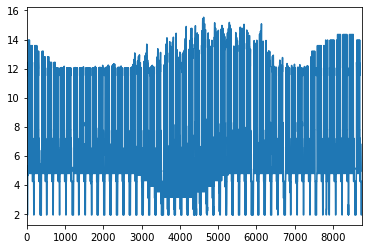

In [12]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [13]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 2,059.56
14.35221199000051


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [14]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

energy_plus/output_energy_plus/rbf-cost-106-2-6/eplusout.sql
Roof area is 599 m2
Roof area is up 29 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [15]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.3565526008605957 sec


ERROR:root:Finished Generation of Irradiance


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7917208671569824 sec


ERROR:root:Finished Generation of Irradiance


0.0


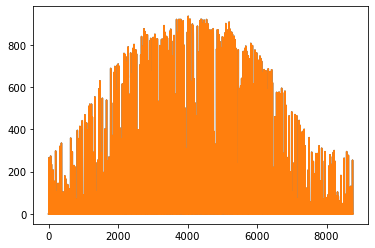

In [16]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(100,1,0.25,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(100,1,0.25,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


(155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)
Loading the model
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,845 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.56


ERROR:ga_logger:panel values: (155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.650


{'name': 'gurobi', 'options': None}
Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2190446853637695 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2276201248168945 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2214667797088623 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


INFO:root:Constraint: calc_investment_cost


INFO:root:Constraint: calc_maintenance_cost


INFO:root:Constraint: calc_operating_cost


INFO:root:Constraint: calc_total_carbon


INFO:root:Constraint: calc_total_cost


INFO:root:Constraint: constrain_max_energy


INFO:root:Constraint: daily_c_lower_medlar


INFO:root:Constraint: daily_c_lower_small


INFO:root:Constraint: daily_c_upper_medlar


INFO:root:Constraint: daily_c_upper_small


INFO:root:Constraint: energy_balance


INFO:root:Constraint: force_install


INFO:root:Constraint: large_lower


INFO:root:Constraint: large_operating_export_lower


INFO:root:Constraint: large_operating_export_upper


INFO:root:Constraint: large_operating_import_lower


INFO:root:Constraint: large_operating_import_upper


INFO:root:Constraint: large_upper


INFO:root:Constraint: max_carbon_level


INFO:root:Constraint: max_track_constraint


INFO:root:Constraint: med_operating_export_lower


INFO:root:Constraint: med_operating_export_upper


INFO:root:Constraint: med_operating_import_lower


INFO:root:Constraint: med_operating_import_upper


INFO:root:Constraint: medium_lower


INFO:root:Constraint: medium_upper


INFO:root:Constraint: monthly_bill_lower


INFO:root:Constraint: monthly_bill_upper


INFO:root:Constraint: monthly_export_constraint


INFO:root:Constraint: monthly_import_constraint


INFO:root:Constraint: net_metering_constraint


INFO:root:Constraint: roof_tech_area_below_max


INFO:root:Constraint: roof_tech_area_definition


INFO:root:Constraint: roof_tech_cap_max


INFO:root:Constraint: small_demand_charge_constraint


INFO:root:Constraint: small_operating_export_lower


INFO:root:Constraint: small_operating_export_upper


INFO:root:Constraint: small_operating_import_lower


INFO:root:Constraint: small_operating_import_upper


INFO:root:Constraint: storage_balance


INFO:root:Constraint: storage_charge_rate


INFO:root:Constraint: storage_discharge_rate


INFO:root:Constraint: storage_input_positive


INFO:root:Constraint: storage_is_installed


INFO:root:Constraint: storage_is_installed_2


INFO:root:Constraint: storage_level_above_minimum


INFO:root:Constraint: storage_level_below_capacity


INFO:root:Constraint: storage_level_positive


INFO:root:Constraint: storage_looping


INFO:root:Constraint: storage_output_positive


INFO:root:Constraint: tech_export_positive


INFO:root:Constraint: tech_import_positive


INFO:root:Constraint: tech_input_below_capacity


INFO:root:Constraint: tech_input_positive


INFO:root:Constraint: tech_is_installed


INFO:root:Constraint: tech_is_installed_2


INFO:root:Constraint: tech_is_on


INFO:root:Constraint: tech_is_on_2


INFO:root:Constraint: tech_part_loads


INFO:root:Constraint: total_export_value_constraint


INFO:root:Constraint: total_import_value_constraint


INFO:root:Constraint: total_roof_area_definition


INFO:root:Constraint: track_above_150_constraint_lower


INFO:root:Constraint: track_above_150_constraint_upper


INFO:root:Constraint: track_above_35_constraint_lower


INFO:root:Constraint: track_above_35_constraint_upper


INFO:root:Constraint: track_above_550_constraint_lower


INFO:root:Constraint: track_above_550_constraint_upper


INFO:root:Constraint: track_any_above_150_constraint_lower


INFO:root:Constraint: track_any_above_150_constraint_upper


INFO:root:Constraint: track_any_above_35_constraint_lower


INFO:root:Constraint: track_any_above_35_constraint_upper


INFO:root:Constraint: track_or_constraint_lower


INFO:root:Constraint: track_or_constraint_upper


INFO:root:Constraint: track_or_constraint_upper2


INFO:root:Constraint List: capacity_bounds


ERROR:ga_logger:Recompiled the model in 212 s


ERROR:ga_logger:Starting solver


None


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [307.53518498812736, 0.0, 0.0]


ERROR:ga_logger:Cost: 3187.5574048188814


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


Total Electricity Imported from the grid 50,271 kWh
At a cost of $ 0.1253 /kWh
Total Cost of the system: $ 3,188 per year


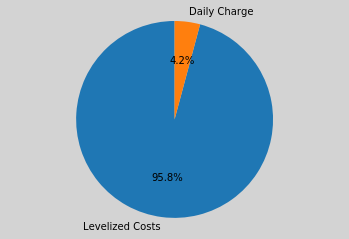

Total roof area of the  building: 599 m2
Total roof area used 473 m2
Percentage: 79.0%


In [17]:
from pv_model import pvModel
# this was the optimal solution
pan_vals = (155,175,260,26,36,36,0.65,0.7,0.9)
gcr=(0.65,0.7,0.9)
print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.

default_settings={
                    'name': 'gurobi',
                    'options':None
                    }
# preload the excel
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels,
                           factor_multiplier=1.5,
                           solver_settings=default_settings)
my_model.eval_model(pan_vals,106,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [18]:
my_model.energyIm

50270.728631185906

In [19]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    0.0
dtype: float64

In [20]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr     3953.588272
Aug     4232.535574
Dec     4728.407874
Feb     4220.904101
Jan     4695.625513
Jul     3596.797122
Jun     3505.544383
Mar     4553.295110
May     3930.927926
Nov     4284.410932
Oct     4521.675077
Sep     4047.016748
monthly_import    50270.728631
dtype: float64
50270.728631185906
     monthly_export
Apr     6047.180913
Aug     6614.423308
Dec      804.969294
Feb     2251.160819
Jan      895.761370
Jul     7708.016021
Jun     6371.405780
Mar     3649.482470
May     7091.115573
Nov      925.105855
Oct     2596.898286
Sep     5315.108943
monthly_export    50270.628631
dtype: float64
50270.62863118734
133.0424999999616


In [21]:
my_model.solveResults['solution']['daily_charge_c']

133.0424999999616

In [22]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng           1.0
Grid               1.0
Invertor           1.0
PV0                1.0
PV1                0.0
PV2                0.0

In [23]:
my_model.solveResults['solution']['any_above_35']

0.0

In [24]:
my_model.solveResults['solution']['a150_or_a550']

0.0

# (D) GA - Optimize the model

In [25]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

In [26]:
# preload the excel
from pyehub.excel_to_request_format import convert

request_format = convert(excel_file=ehub_file)

In [27]:
import time
t1=time.time()

pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                         range_tilt=range_tilt,
                         range_gcr=range_gcr,
                         pvpanel=pvpanel,
                         price=price,
                         store_file=ga_file,
                         ehub_request=request_format,
                         res_file=res_file,
                         pvbuilding=pvbuilding,
                         roof_area_per_unit_capacity=roof_area_per_unit_capacity,
                         ga_proc=ga_proc,
                         solver_settings=default_settings,
                         force_install=False)



ERROR:optimizer_logger:Found the solver set


/home/theochri/paper_pusher/lib/python3.6/site-packages/besos/evaluator.py:395: FutureWarning: EvaluatorSR has been renamed as EvaluatorGeneric with same functionaility. EvaluatorSR will be removed in a future release.
  warn(msg, FutureWarning)
ERROR:optimizer_logger:The number of evaluations is 200


[90.  90.  90.   1.   1.   1.   0.2  0.2  0.2] [265.  265.  265.   56.   56.   56.    0.9   0.9   0.9] ['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R']


ERROR:ga_logger:panel values: (139.5468272027765, 192.4117199849888, 90.32885529507949, 51.19511182420572, 24.261613955075727, 20.567271478510406, 0.4736975808760432, 0.29195834589770064, 0.2709730156501557)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 51.2
                                           and a gcr of 0.474


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.397294282913208 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 24.3
                                           and a gcr of 0.292


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2587854862213135 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 20.6
                                           and a gcr of 0.271


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2859222888946533 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 209 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [283.63195989629554, 0.0, 0.0]


ERROR:ga_logger:Cost: 4069.561314151225


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


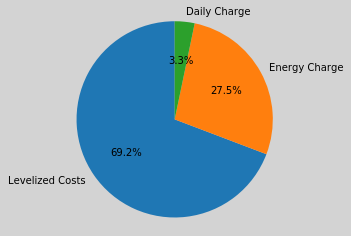

ERROR:ga_logger:panel values: (173.8701605762694, 119.7069921716385, 187.05398221077485, 39.788409375909886, 44.03894489216408, 36.17237778541084, 0.7210423202013772, 0.5384965383538027, 0.8915426628746299)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 174
                                           a tilt of 39.8
                                           and a gcr of 0.721


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2276599407196045 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 44.0
                                           and a gcr of 0.538


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.232337474822998 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 187
                                           a tilt of 36.2
                                           and a gcr of 0.892


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3371644020080566 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 210 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [312.53738784852817, 0.0, 0.0]


ERROR:ga_logger:Cost: 3237.2402985990166


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


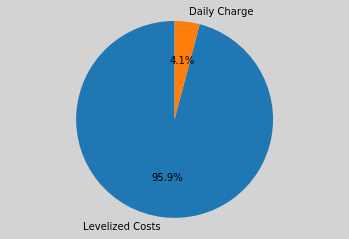

ERROR:ga_logger:panel values: (255.68177701222214, 131.92656955807507, 127.05567905480535, 17.274554571039126, 12.791823751228574, 3.2304047375630214, 0.8779592964625254, 0.7046697614568742, 0.5754776986796656)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 256
                                           a tilt of 17.3
                                           and a gcr of 0.878


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8140642642974854 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 132
                                           a tilt of 12.8
                                           and a gcr of 0.705


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.345210552215576 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 127
                                           a tilt of 3.2
                                           and a gcr of 0.575


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2375996112823486 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  26 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 196 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [0.0, 320.8389414613058, 0.0]


ERROR:ga_logger:Cost: 3319.6929598472407


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


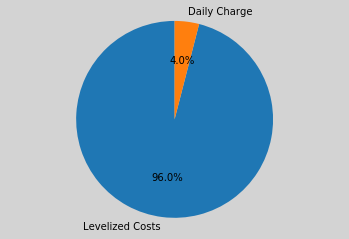

ERROR:ga_logger:panel values: (120.21378821635084, 200.20840261643963, 195.46143036225197, 6.472285780887505, 50.57322611630932, 31.13326863380387, 0.5033170319231883, 0.89999144466817, 0.3956105252049218)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 6.5
                                           and a gcr of 0.503


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.202547311782837 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 50.6
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.220970630645752 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 31.1
                                           and a gcr of 0.396


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2772018909454346 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  20 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 197 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [0.0, 146.20475254246023, 172.60899119741106]


ERROR:ga_logger:Cost: 3299.5783173687196


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


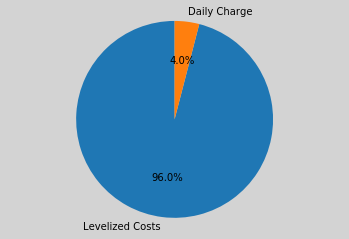

ERROR:ga_logger:panel values: (228.20254610269876, 261.5583490195295, 256.197404582365, 25.13325828646022, 4.909903312772263, 46.2919313965883, 0.3227991760805772, 0.4218981638977733, 0.6788163769278026)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 228
                                           a tilt of 25.1
                                           and a gcr of 0.323


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8022613525390625 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 262
                                           a tilt of 4.9
                                           and a gcr of 0.422


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.796701431274414 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 256
                                           a tilt of 46.3
                                           and a gcr of 0.679


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.284027338027954 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 200 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 406.4492350613978]


ERROR:ga_logger:Cost: 4282.931335573354


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


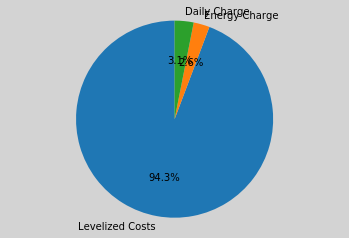

ERROR:ga_logger:panel values: (177.5, 177.5, 177.5, 28.5, 28.5, 28.5, 0.5499999999999999, 0.5499999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 178
                                           a tilt of 28.5
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.336331605911255 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 178
                                           a tilt of 28.5
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.332481861114502 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 178
                                           a tilt of 28.5
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3216521739959717 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 191 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 297.16115923082754]


ERROR:ga_logger:Cost: 3084.5205097866624


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


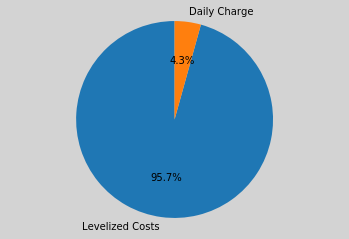

ERROR:ga_logger:panel values: (262.3345241644722, 90.7302766837438, 264.0417831059012, 1.6387663132925414, 55.01053266599631, 2.6221462622360088, 0.21708788310511348, 0.20591664362657763, 0.20285415629171194)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 1.6
                                           and a gcr of 0.217


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0875356197357178 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 91
                                           a tilt of 55.0
                                           and a gcr of 0.206


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.273677349090576 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 264
                                           a tilt of 2.6
                                           and a gcr of 0.203


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1429522037506104 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 220 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 43s


ERROR:ga_logger:panel relevance: [129.98390585171506, 0.0, 0.0]


ERROR:ga_logger:Cost: 6175.100165005082


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


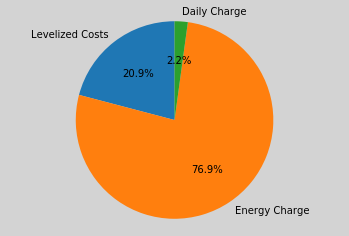

ERROR:ga_logger:panel values: (90.72591471992904, 91.5039964306185, 264.0829761180094, 52.6099473861528, 1.286484670453671, 55.65970975036093, 0.8962787564091015, 0.896266983720339, 0.20987151781273164)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 52.6
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2204039096832275 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 92
                                           a tilt of 1.3
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.162991762161255 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 264
                                           a tilt of 55.7
                                           and a gcr of 0.210


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.335333824157715 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 219 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [0.0, 335.88685997805726, 0.0]


ERROR:ga_logger:Cost: 3469.1518858965155


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


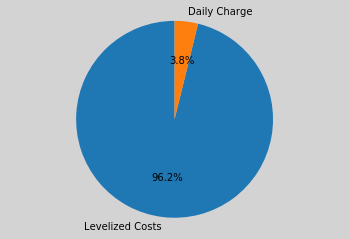

ERROR:ga_logger:panel values: (90.94449570045235, 91.66784895256004, 96.12684681802591, 2.089793805595127, 1.696500547902927, 1.5456533044015344, 0.20736809280098256, 0.8958657155876191, 0.895774648127214)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 2.1
                                           and a gcr of 0.207


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.218935966491699 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 92
                                           a tilt of 1.7
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.16377329826355 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 96
                                           a tilt of 1.5
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.114572048187256 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 223 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [60.50365287789493, 0.0, 274.9959507636331]


ERROR:ga_logger:Cost: 3465.3055786491427


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


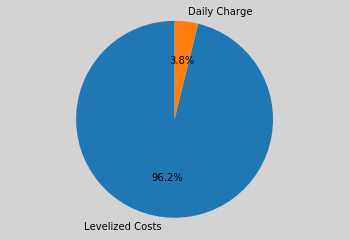

ERROR:ga_logger:panel values: (149.0397727039448, 206.20141601931712, 201.52760176947862, 19.951381428936983, 20.112524671331926, 19.840130653509906, 0.6627206742566041, 0.4360596194221461, 0.6636269565180806)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 149
                                           a tilt of 20.0
                                           and a gcr of 0.663


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2133593559265137 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 206
                                           a tilt of 20.1
                                           and a gcr of 0.436


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.259066343307495 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 202
                                           a tilt of 19.8
                                           and a gcr of 0.664


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3371355533599854 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 224 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [0.0, 176.24726569424502, 129.12860073778424]


ERROR:ga_logger:Cost: 3166.110615143702


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


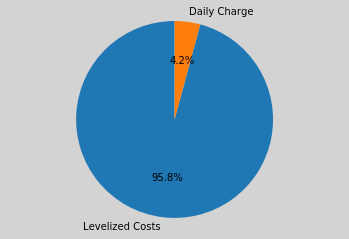

ERROR:ga_logger:panel values: (150.58337223956528, 152.38874895526584, 149.88921305222098, 19.47527312138364, 20.749691666598917, 37.00094910091772, 0.661681865983544, 0.437466054868894, 0.4376318923432255)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 151
                                           a tilt of 19.5
                                           and a gcr of 0.662


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2401065826416016 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 152
                                           a tilt of 20.7
                                           and a gcr of 0.437


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2870821952819824 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 37.0
                                           and a gcr of 0.438


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.260831832885742 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 222 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [127.54060116838019, 177.6153885821762, 0.0]


ERROR:ga_logger:Cost: 3163.926755968635


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


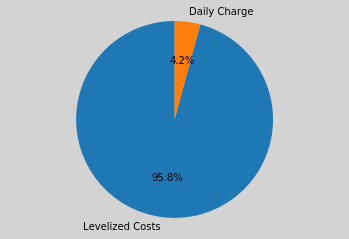

ERROR:ga_logger:panel values: (90.00000000005129, 264.999999999947, 90.00000000002802, 1.0000000003846412, 15.378147192712895, 55.999999999981874, 0.8999999999999269, 0.8999999999998938, 0.8999999999998625)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.3157613277435303 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 15.4
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3235578536987305 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.242556095123291 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 218 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [335.9895092902932, 0.0, 0.0]


ERROR:ga_logger:Cost: 3470.171419323283


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


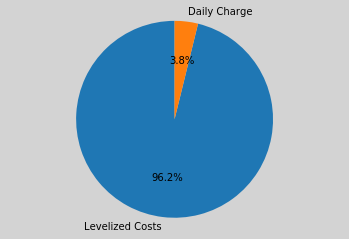

ERROR:ga_logger:panel values: (91.78849050754934, 164.24123160327767, 94.50768540110666, 55.8767425619316, 2.2172685414165345, 11.712015726665452, 0.8988804793829077, 0.8991340122346725, 0.8688767574804934)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 55.9
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2119972705841064 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 164
                                           a tilt of 2.2
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2679903507232666 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 11.7
                                           and a gcr of 0.869


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.343862771987915 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 219 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 330.5758059319503, 0.0]


ERROR:ga_logger:Cost: 3416.4014367144396


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


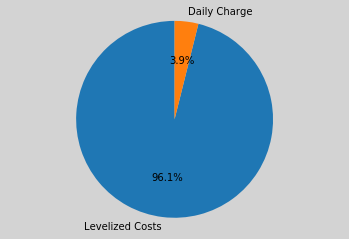

ERROR:ga_logger:panel values: (91.22297482883579, 90.4163064867354, 195.85817801215285, 4.3884598408105155, 3.115861244629899, 36.073012675690705, 0.8946912487531982, 0.8913357303909746, 0.8914893735816889)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 4.4
                                           and a gcr of 0.895


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3863112926483154 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 3.1
                                           and a gcr of 0.891


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1782186031341553 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 196
                                           a tilt of 36.1
                                           and a gcr of 0.891


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3090295791625977 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 213 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 328.7205906014055]


ERROR:ga_logger:Cost: 3397.975103222231


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


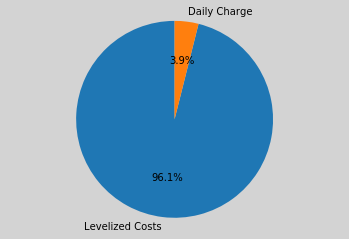

ERROR:ga_logger:panel values: (112.23897172636691, 169.94769073633375, 102.13798683457316, 11.471352977991325, 38.0786738273048, 13.891546334979722, 0.8898400762760381, 0.8969362073998866, 0.8174169763242127)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 112
                                           a tilt of 11.5
                                           and a gcr of 0.890


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6686389446258545 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 38.1
                                           and a gcr of 0.897


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3073222637176514 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 102
                                           a tilt of 13.9
                                           and a gcr of 0.817


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2979228496551514 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in 148 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 229 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 329.010233721982, 0.0]


ERROR:ga_logger:Cost: 3400.85189894674


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


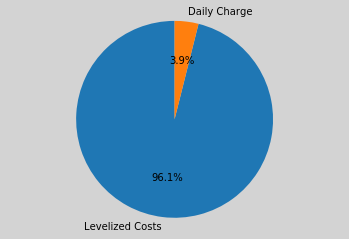

ERROR:ga_logger:panel values: (149.1491774056258, 155.99798217791698, 153.49043039464127, 25.849545977072463, 19.52402767332472, 37.1347963662837, 0.6652500765394889, 0.6641121313269172, 0.6576020640473732)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 149
                                           a tilt of 25.8
                                           and a gcr of 0.665


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2631757259368896 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 156
                                           a tilt of 19.5
                                           and a gcr of 0.664


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2788259983062744 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 153
                                           a tilt of 37.1
                                           and a gcr of 0.658


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.309211254119873 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 227 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 307.97412889938505, 0.0]


ERROR:ga_logger:Cost: 3191.917078099842


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


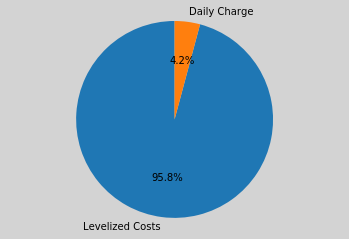

ERROR:ga_logger:panel values: (155.67926518822577, 188.44845260620457, 189.23068471961278, 26.28433152034558, 34.996135901384115, 26.753700840478565, 0.6648241528622834, 0.6597676858368865, 0.510922796160844)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 26.3
                                           and a gcr of 0.665


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.284407377243042 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 188
                                           a tilt of 35.0
                                           and a gcr of 0.660


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3274781703948975 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 189
                                           a tilt of 26.8
                                           and a gcr of 0.511


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.378680467605591 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 230 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 296.6241606279449]


ERROR:ga_logger:Cost: 3079.1869303072126


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


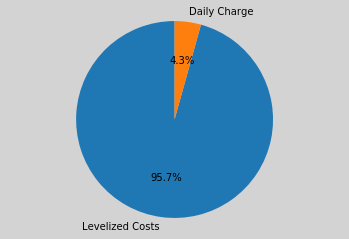

ERROR:ga_logger:panel values: (172.67699198956046, 173.5593609549615, 174.5505921413195, 24.088907544095463, 29.073179192680144, 26.37320934795898, 0.6830621968312773, 0.5563382712194611, 0.5899944166123418)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 173
                                           a tilt of 24.1
                                           and a gcr of 0.683


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.267679452896118 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 174
                                           a tilt of 29.1
                                           and a gcr of 0.556


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3085668087005615 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 26.4
                                           and a gcr of 0.590


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3345377445220947 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 225 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 297.73882029192674, 0.0]


ERROR:ga_logger:Cost: 3090.257955371539


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


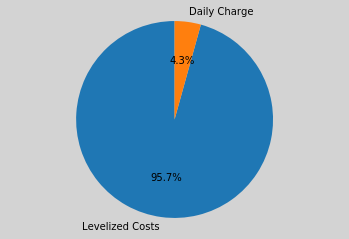

ERROR:ga_logger:panel values: (91.06092817633697, 93.3537084058932, 263.16603829719315, 49.197588565775206, 8.271795251618798, 1.2991820176591964, 0.3917345775971425, 0.8993735431900114, 0.8997664999362023)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 49.2
                                           and a gcr of 0.392


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2629988193511963 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 93
                                           a tilt of 8.3
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.262714385986328 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 263
                                           a tilt of 1.3
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.098513126373291 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in 108 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 232 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 116s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 336.1969198201223]


ERROR:ga_logger:Cost: 3472.231462174248


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


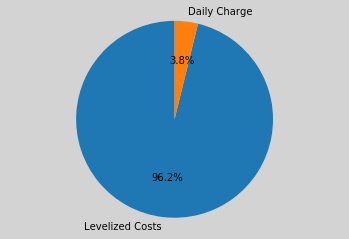

ERROR:ga_logger:panel values: (92.42464869257032, 260.2988696582278, 142.35672561131196, 1.2519574566976974, 3.550960536176203, 1.383226334583796, 0.8502081265760719, 0.8962767137712921, 0.2755654697404456)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 1.3
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.156339406967163 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 3.6
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.379267454147339 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 142
                                           a tilt of 1.4
                                           and a gcr of 0.276


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1910006999969482 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  81 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 227 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [251.45319679912646, 0.0, 83.49821333309032]


ERROR:ga_logger:Cost: 3459.860811159039


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


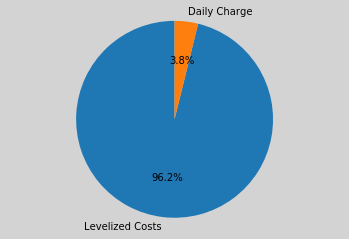

ERROR:ga_logger:panel values: (90.90401867225349, 220.58517175499952, 258.06137372403026, 55.77827767465668, 31.96132951663222, 10.187327798493264, 0.8841424078796996, 0.8937286600278829, 0.8884696505664356)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 55.8
                                           and a gcr of 0.884


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2726354598999023 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 221
                                           a tilt of 32.0
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3742096424102783 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 258
                                           a tilt of 10.2
                                           and a gcr of 0.888


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6030869483947754 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in 104 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 229 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 346.90547088333494]


ERROR:ga_logger:Cost: 3578.5909348901737


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


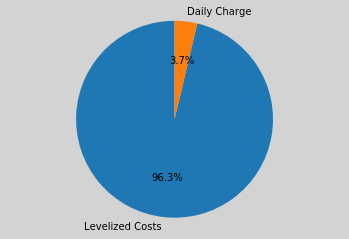

ERROR:ga_logger:panel values: (127.71951721973545, 166.64484852156892, 190.84201603299536, 24.086745905937207, 26.832335836770035, 30.76334169833301, 0.5534207449344899, 0.5969291493245803, 0.5348149002141538)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 128
                                           a tilt of 24.1
                                           and a gcr of 0.553


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.191655397415161 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 167
                                           a tilt of 26.8
                                           and a gcr of 0.597


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.285038709640503 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 191
                                           a tilt of 30.8
                                           and a gcr of 0.535


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.285919666290283 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  19 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 166 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 297.38294755692385]


ERROR:ga_logger:Cost: 3086.723357293277


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


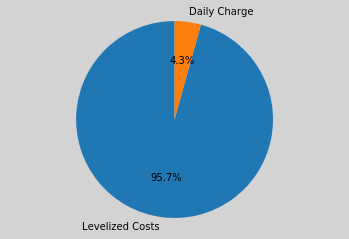

ERROR:ga_logger:panel values: (156.41412556175578, 179.48533999607744, 184.43637048993855, 25.999674980711582, 30.426896357092733, 30.17824228560322, 0.5946312150405686, 0.6081615815184329, 0.5404974343334701)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 26.0
                                           and a gcr of 0.595


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.285959005355835 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 179
                                           a tilt of 30.4
                                           and a gcr of 0.608


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3158252239227295 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 184
                                           a tilt of 30.2
                                           and a gcr of 0.540


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.323317527770996 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 188 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 295.9968344319459]


ERROR:ga_logger:Cost: 3072.9562046374053


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


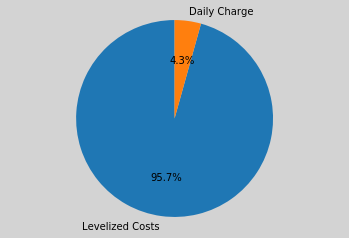

ERROR:ga_logger:panel values: (160.09915242164837, 172.96515939205977, 184.5491836381292, 28.69455624874155, 27.732559565305866, 25.30244557818729, 0.6079281899349749, 0.6071753812086023, 0.536646092963367)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 28.7
                                           and a gcr of 0.608


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.296513795852661 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 173
                                           a tilt of 27.7
                                           and a gcr of 0.607


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.273977041244507 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 25.3
                                           and a gcr of 0.537


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2819321155548096 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 183 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 296.7169664558362]


ERROR:ga_logger:Cost: 3080.108695688175


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


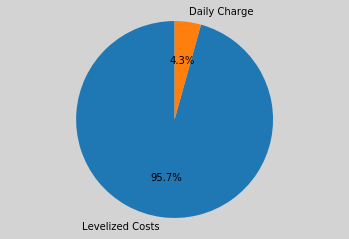

ERROR:ga_logger:panel values: (168.95129189202464, 166.87029260057994, 213.9765751690261, 26.457528211204806, 29.984422864765463, 34.24594737869902, 0.6207145906672034, 0.605434664230745, 0.5310316559525167)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 169
                                           a tilt of 26.5
                                           and a gcr of 0.621


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.269601821899414 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 167
                                           a tilt of 30.0
                                           and a gcr of 0.605


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.269643545150757 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 214
                                           a tilt of 34.2
                                           and a gcr of 0.531


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.46134877204895 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 188 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [301.2811261060668, 0.0, 0.0]


ERROR:ga_logger:Cost: 3125.4408431981647


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


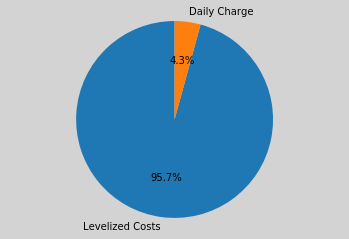

ERROR:ga_logger:panel values: (162.29579747611626, 179.31924737659554, 184.60918016616614, 21.79098426799823, 28.850752159531233, 28.925183198219287, 0.5757685772032493, 0.6399410455870684, 0.5266965823551069)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 162
                                           a tilt of 21.8
                                           and a gcr of 0.576


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.411400318145752 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 179
                                           a tilt of 28.9
                                           and a gcr of 0.640


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4208524227142334 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 28.9
                                           and a gcr of 0.527


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.459179401397705 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 211 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 295.6731804251888]


ERROR:ga_logger:Cost: 3069.741607093426


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


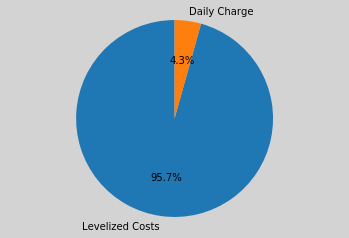

ERROR:ga_logger:panel values: (155.63689676645544, 186.70623315535204, 186.6700336506534, 26.002104427549867, 28.80842832118771, 30.19721004796911, 0.5991742464610448, 0.6019872522988181, 0.5420031072237133)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 26.0
                                           and a gcr of 0.599


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.344935894012451 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 187
                                           a tilt of 28.8
                                           and a gcr of 0.602


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3452982902526855 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 187
                                           a tilt of 30.2
                                           and a gcr of 0.542


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2973146438598633 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 220 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 296.5358016663838]


ERROR:ga_logger:Cost: 3078.3093348670895


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


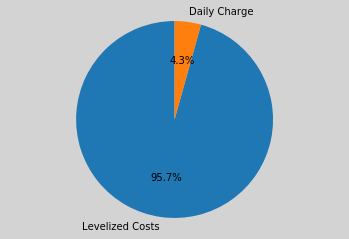

ERROR:ga_logger:panel values: (156.27667610801498, 179.95277126341261, 185.72855059936154, 25.993570907253137, 30.754058094851555, 29.770206995339763, 0.5890673899518398, 0.6119053657251612, 0.5557449930149698)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 26.0
                                           and a gcr of 0.589


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2801644802093506 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 30.8
                                           and a gcr of 0.612


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2938594818115234 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 186
                                           a tilt of 29.8
                                           and a gcr of 0.556


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.289400100708008 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 223 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 296.7809139588113]


ERROR:ga_logger:Cost: 3080.743839053084


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


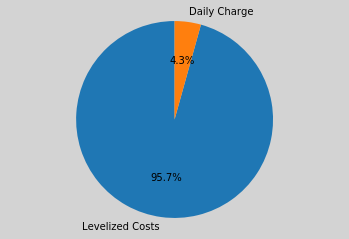

ERROR:ga_logger:panel values: (156.390102715732, 179.38477725238576, 182.80946332003822, 26.144373865039448, 30.263916001460693, 30.462834157758746, 0.5955088914179987, 0.6127280783410942, 0.5387326325211286)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 26.1
                                           and a gcr of 0.596


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.592274904251099 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 179
                                           a tilt of 30.3
                                           and a gcr of 0.613


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.644251346588135 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 183
                                           a tilt of 30.5
                                           and a gcr of 0.539


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.343195915222168 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  18 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 217 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 295.62096095100424]


ERROR:ga_logger:Cost: 3069.2229543759195


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


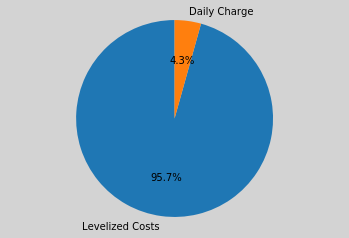

ERROR:ga_logger:panel values: (263.1269366650629, 159.8221221899199, 93.32226767041372, 54.52244718221333, 52.30524501898225, 54.479425510352975, 0.8903813604689907, 0.8955879123891555, 0.43523376895638277)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 263
                                           a tilt of 54.5
                                           and a gcr of 0.890


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2695963382720947 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 52.3
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4051008224487305 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 93
                                           a tilt of 54.5
                                           and a gcr of 0.435


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.315049171447754 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  95 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 225 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 356.8369897385199, 0.0]


ERROR:ga_logger:Cost: 3677.2328128626955


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


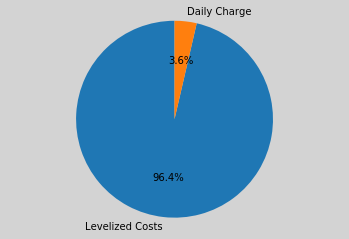

ERROR:ga_logger:panel values: (90.43623070661008, 92.78391652880624, 181.0463596531326, 29.93637587724155, 43.970688608080884, 54.052534685065524, 0.881847540926459, 0.8839676008661332, 0.2983949207702474)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 29.9
                                           and a gcr of 0.882


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3840575218200684 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 93
                                           a tilt of 44.0
                                           and a gcr of 0.884


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.271536111831665 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 54.1
                                           and a gcr of 0.298


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6413612365722656 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 221 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [324.3227444479107, 0.0, 68.92482435720761]


ERROR:ga_logger:Cost: 4038.869928072958


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


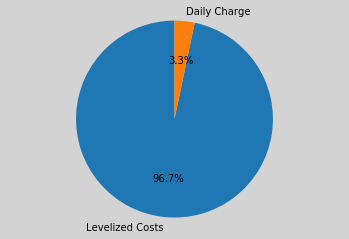

ERROR:ga_logger:panel values: (252.03379958053628, 114.01690601119094, 196.98142180445694, 55.32622358045425, 2.8315539586261584, 28.884666889627237, 0.8969417408383344, 0.8803239691671481, 0.882581775440179)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 252
                                           a tilt of 55.3
                                           and a gcr of 0.897


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.311678886413574 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 114
                                           a tilt of 2.8
                                           and a gcr of 0.880


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.19619083404541 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 197
                                           a tilt of 28.9
                                           and a gcr of 0.883


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.324324369430542 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 223 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 323.72910759829676]


ERROR:ga_logger:Cost: 3348.3986889365383


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


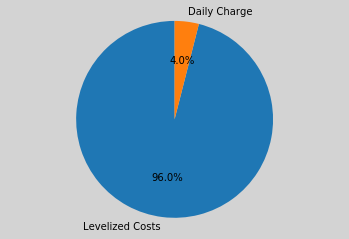

ERROR:ga_logger:panel values: (184.70282389334594, 193.60999058350504, 154.6018462558145, 27.41069567482675, 32.31688451041198, 32.720342267129794, 0.6134342388067676, 0.7271447547325844, 0.4242575805172454)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 27.4
                                           and a gcr of 0.613


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3188984394073486 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 194
                                           a tilt of 32.3
                                           and a gcr of 0.727


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.289367914199829 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 32.7
                                           and a gcr of 0.424


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2997329235076904 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 220 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [144.92356869387214, 0.0, 153.79851565662494]


ERROR:ga_logger:Cost: 3100.0239302455675


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


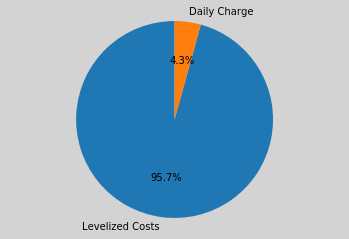

ERROR:ga_logger:panel values: (159.93781460533557, 184.48539927177256, 168.05464630176516, 24.01124452235316, 28.494938254261594, 30.378100024453683, 0.6070515090794348, 0.6407622042439605, 0.45925295569092556)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 24.0
                                           and a gcr of 0.607


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4999921321868896 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 184
                                           a tilt of 28.5
                                           and a gcr of 0.641


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3510332107543945 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 168
                                           a tilt of 30.4
                                           and a gcr of 0.459


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3351285457611084 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 228 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 75.85761539757326, 220.61370695800224]


ERROR:ga_logger:Cost: 3077.668912440687


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


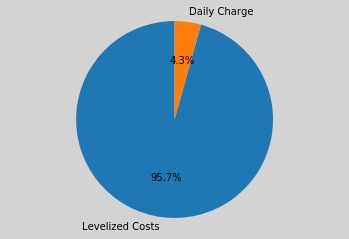

ERROR:ga_logger:panel values: (169.74493703756292, 177.72532792091792, 175.49401235803816, 26.940868237505747, 29.838741713290602, 31.317339045668238, 0.5975948994294914, 0.6407682868598753, 0.5144522036468191)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 26.9
                                           and a gcr of 0.598


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2546868324279785 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 178
                                           a tilt of 29.8
                                           and a gcr of 0.641


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.275820016860962 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 31.3
                                           and a gcr of 0.514


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3026511669158936 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 232 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 153s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 296.10590687124386]


ERROR:ga_logger:Cost: 3074.0395341734143


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


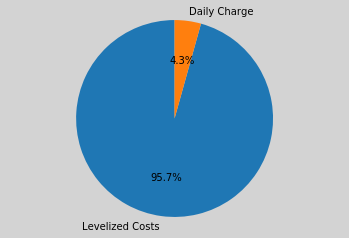

ERROR:ga_logger:panel values: (260.6424446519799, 261.4248040412395, 90.10828492546563, 31.539650657060328, 2.1978866780677118, 35.826550861963895, 0.8843357768363018, 0.8873237644132714, 0.8863076929103915)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 261
                                           a tilt of 31.5
                                           and a gcr of 0.884


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5917911529541016 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 261
                                           a tilt of 2.2
                                           and a gcr of 0.887


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.273974657058716 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 35.8
                                           and a gcr of 0.886


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3796780109405518 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  27 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 221 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 336.18649236714424, 0.0]


ERROR:ga_logger:Cost: 3472.127894813309


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


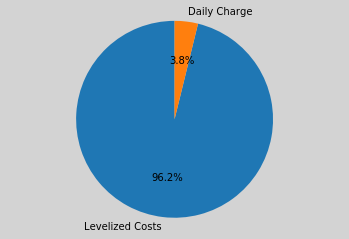

ERROR:ga_logger:panel values: (94.5553413248443, 260.5264248397066, 134.64593008643493, 9.795606096714346, 1.2621971288878355, 31.430773187030383, 0.21103248111490985, 0.8937817572644544, 0.885114568833659)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 9.8
                                           and a gcr of 0.211


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.249239683151245 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 261
                                           a tilt of 1.3
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.366347074508667 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 31.4
                                           and a gcr of 0.885


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.408625364303589 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in 166 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 233 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [61.722566171968474, 273.74988516964896, 0.0]


ERROR:ga_logger:Cost: 3465.0358966733374


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


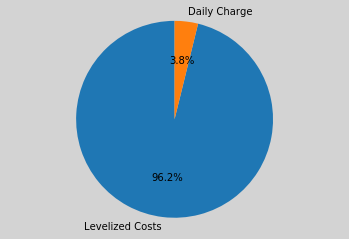

ERROR:ga_logger:panel values: (161.4105185788617, 174.94885591117523, 189.71480283475856, 19.282045054790146, 2.8096944119844975, 2.2772922625504597, 0.8050080409356672, 0.8970765857129896, 0.8863439499970742)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 161
                                           a tilt of 19.3
                                           and a gcr of 0.805


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2642393112182617 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 2.8
                                           and a gcr of 0.897


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2105257511138916 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 2.3
                                           and a gcr of 0.886


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1815073490142822 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  28 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 227 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [314.65359709951866, 0.0, 0.0]


ERROR:ga_logger:Cost: 3258.2588931704718


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


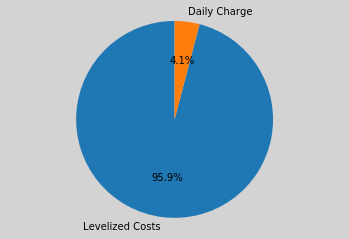

ERROR:ga_logger:panel values: (143.41804336355494, 200.9139599763226, 182.49688517934578, 17.450165375427883, 24.916888852310432, 23.863868440131878, 0.6754897327144014, 0.7191090577770884, 0.5253556345786613)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 143
                                           a tilt of 17.5
                                           and a gcr of 0.675


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2715373039245605 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 201
                                           a tilt of 24.9
                                           and a gcr of 0.719


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.425111770629883 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 182
                                           a tilt of 23.9
                                           and a gcr of 0.525


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3040778636932373 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  52 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 236 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 296.74110156020754]


ERROR:ga_logger:Cost: 3080.3484090895313


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


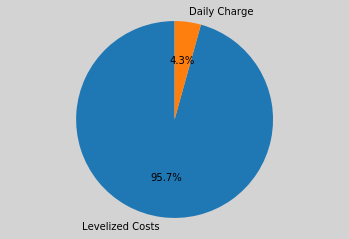

ERROR:ga_logger:panel values: (159.31180692541042, 191.63222311768556, 175.98358179980877, 21.75637393722288, 30.172229727108263, 28.296686959549543, 0.6313661849489035, 0.721322098047452, 0.5146991930093823)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 159
                                           a tilt of 21.8
                                           and a gcr of 0.631


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2739675045013428 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 30.2
                                           and a gcr of 0.721


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.339878559112549 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 176
                                           a tilt of 28.3
                                           and a gcr of 0.515


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3021090030670166 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 239 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 296.05334617785076]


ERROR:ga_logger:Cost: 3073.5174884507546


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


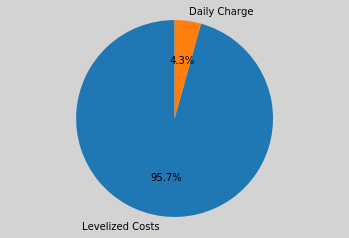

ERROR:ga_logger:panel values: (151.35893079056186, 175.93144989516017, 178.52131863695172, 21.9212598691982, 24.80436885471482, 29.169931873430862, 0.6141485372816786, 0.5918315913481564, 0.5231760120028393)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 151
                                           a tilt of 21.9
                                           and a gcr of 0.614


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2708213329315186 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 176
                                           a tilt of 24.8
                                           and a gcr of 0.592


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2649788856506348 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 179
                                           a tilt of 29.2
                                           and a gcr of 0.523


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3611466884613037 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 235 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 296.1612948395246]


ERROR:ga_logger:Cost: 3074.589656993165


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


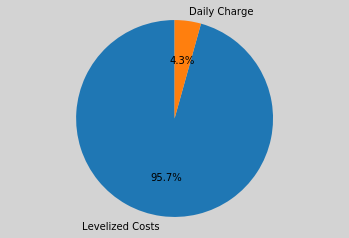

ERROR:ga_logger:panel values: (238.2407754894267, 260.7482848314164, 90.4116994347677, 3.2859014992555524, 55.28416330458291, 55.751556140431724, 0.8959598260504646, 0.48030495384065536, 0.8984769042266909)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 238
                                           a tilt of 3.3
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0874879360198975 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 261
                                           a tilt of 55.3
                                           and a gcr of 0.480


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3111822605133057 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 55.8
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8745641708374023 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  30 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 237 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 123s


ERROR:ga_logger:panel relevance: [333.20441844071297, 0.0, 0.0]


ERROR:ga_logger:Cost: 3442.5093414570556


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


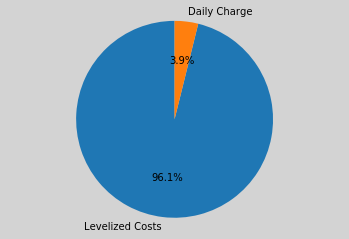

ERROR:ga_logger:panel values: (92.4498120299921, 104.99880347206847, 193.6148427016616, 48.88935581918741, 2.3176676141970862, 24.035542757455953, 0.866802487512004, 0.22496796803578353, 0.8834538644865206)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 48.9
                                           and a gcr of 0.867


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.071486473083496 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 2.3
                                           and a gcr of 0.225


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.62294602394104 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 194
                                           a tilt of 24.0
                                           and a gcr of 0.883


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8116021156311035 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 202 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 320.2753362851972]


ERROR:ga_logger:Cost: 3314.09513731011


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


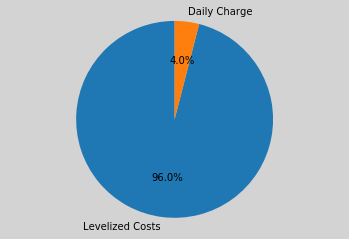

ERROR:ga_logger:panel values: (172.41935069577872, 263.68940463152865, 91.31581158868013, 8.048939313622094, 54.88561632188342, 33.552118015832534, 0.3719844880614984, 0.8414230471668864, 0.882021877525947)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 172
                                           a tilt of 8.0
                                           and a gcr of 0.372


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.417999505996704 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 54.9
                                           and a gcr of 0.841


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4684982299804688 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 33.6
                                           and a gcr of 0.882


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5337789058685303 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 219 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [96.2650019238701, 0.0, 299.8645085798863]


ERROR:ga_logger:Cost: 4067.49394334197


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


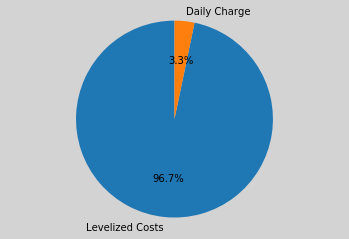

ERROR:ga_logger:panel values: (133.34890223984874, 190.79866618425743, 196.21955345445178, 19.942831342960048, 23.728931553035185, 29.58528148789488, 0.5369628512401431, 0.728014208932201, 0.44233176544325625)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 133
                                           a tilt of 19.9
                                           and a gcr of 0.537


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3350813388824463 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 191
                                           a tilt of 23.7
                                           and a gcr of 0.728


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3462414741516113 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 196
                                           a tilt of 29.6
                                           and a gcr of 0.442


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5026888847351074 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 224 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 87.68568502570356, 211.57465374562528]


ERROR:ga_logger:Cost: 3105.369979238484


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


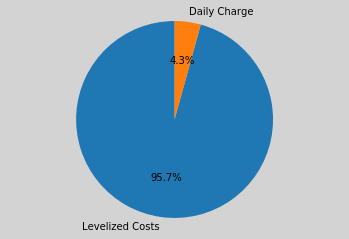

ERROR:ga_logger:panel values: (158.44446336358553, 188.42025151775835, 185.0033415889818, 22.41154903204453, 29.831186755280218, 28.827589894211034, 0.6588596497217851, 0.6536775938380355, 0.49126161499916265)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 158
                                           a tilt of 22.4
                                           and a gcr of 0.659


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.307468891143799 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 188
                                           a tilt of 29.8
                                           and a gcr of 0.654


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6780130863189697 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 28.8
                                           and a gcr of 0.491


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.641965627670288 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 229 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [0.0, 3.053715341442661, 291.8536564220558]


ERROR:ga_logger:Cost: 3062.135441823683


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


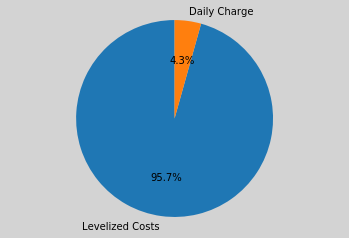

ERROR:ga_logger:panel values: (167.45100899068225, 191.95158287892087, 180.19620044694238, 22.38535276174283, 30.030129338832804, 29.861044476830237, 0.6828779247850041, 0.6650592393181951, 0.48935230439370103)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 22.4
                                           and a gcr of 0.683


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3156721591949463 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 30.0
                                           and a gcr of 0.665


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3189635276794434 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 29.9
                                           and a gcr of 0.489


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9766640663146973 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 220 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 3.8009539684931752, 290.2086567305499]


ERROR:ga_logger:Cost: 3053.218700462995


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


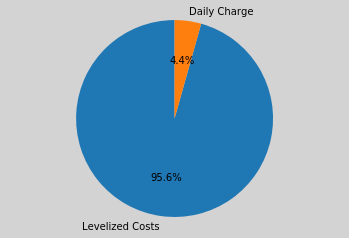

ERROR:ga_logger:panel values: (165.6058656309354, 198.90665176512647, 190.8854537396502, 21.097549037775423, 33.64267576899333, 37.00059042733615, 0.6482571118541836, 0.6831594229325417, 0.45682181739770256)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 166
                                           a tilt of 21.1
                                           and a gcr of 0.648


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3238534927368164 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 199
                                           a tilt of 33.6
                                           and a gcr of 0.683


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3675198554992676 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 191
                                           a tilt of 37.0
                                           and a gcr of 0.457


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3142690658569336 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 228 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [84.60846601954036, 0.0, 213.9044619617621]


ERROR:ga_logger:Cost: 3097.9465493134976


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


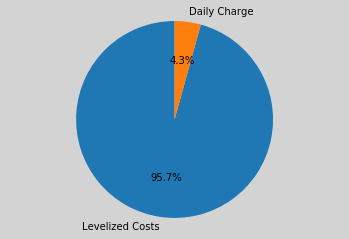

ERROR:ga_logger:panel values: (167.61425581865575, 184.75047097064237, 175.51039204414252, 20.31940238387205, 29.798843385806226, 30.08008808610222, 0.7186350021882162, 0.6511110241253357, 0.5140049927848982)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 168
                                           a tilt of 20.3
                                           and a gcr of 0.719


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3086698055267334 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 29.8
                                           and a gcr of 0.651


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.39677095413208 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 176
                                           a tilt of 30.1
                                           and a gcr of 0.514


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.378243923187256 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 225 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 295.99271513010774]


ERROR:ga_logger:Cost: 3072.915290181697


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


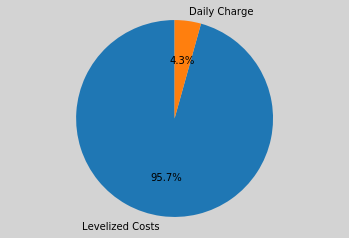

ERROR:ga_logger:panel values: (171.51152333835003, 193.35848342914096, 182.9301002745164, 22.792945569310998, 28.738982111993828, 28.69986072720334, 0.6844413129394242, 0.6669620330328906, 0.48186597205859605)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 172
                                           a tilt of 22.8
                                           and a gcr of 0.684


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.471275568008423 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 193
                                           a tilt of 28.7
                                           and a gcr of 0.667


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3032689094543457 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 183
                                           a tilt of 28.7
                                           and a gcr of 0.482


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.344151735305786 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 223 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [21.830105647808576, 0.0, 273.1538699791348]


ERROR:ga_logger:Cost: 3062.896286319409


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


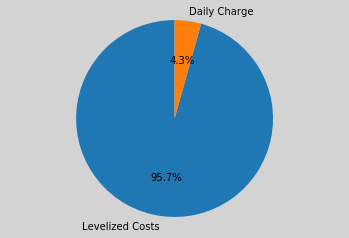

ERROR:ga_logger:panel values: (166.80513677331032, 194.71276871693155, 179.64193002292674, 22.564289584835805, 29.758665622135993, 30.001921794371672, 0.6824963161315507, 0.6592082665851187, 0.4970878212008631)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 22.6
                                           and a gcr of 0.682


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.315807342529297 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 29.8
                                           and a gcr of 0.659


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.324688673019409 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 30.0
                                           and a gcr of 0.497


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4112305641174316 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 217 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 295.2860049175373]


ERROR:ga_logger:Cost: 3065.8961028578597


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


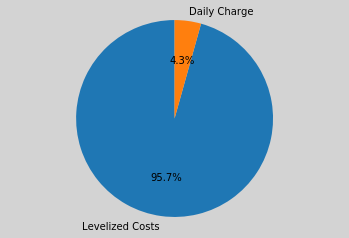

ERROR:ga_logger:panel values: (166.71541897167148, 191.63212897698784, 180.26183635585, 22.71223984964294, 29.785412348339992, 30.064437721674494, 0.6859428913573931, 0.6679373028303864, 0.4888174172288252)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 22.7
                                           and a gcr of 0.686


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3603968620300293 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 29.8
                                           and a gcr of 0.668


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3672080039978027 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 30.1
                                           and a gcr of 0.489


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.401515245437622 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 209 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 5.005073541396525, 289.0222691096037]


ERROR:ga_logger:Cost: 3053.3948179114227


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


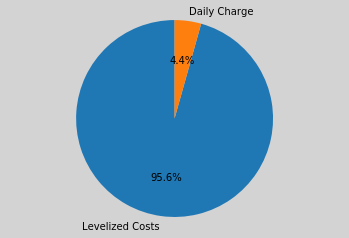

ERROR:ga_logger:panel values: (91.88649643776556, 261.6561748777327, 91.23978066335211, 41.776091779309475, 2.086698719905967, 54.00751976235654, 0.8991828420264278, 0.23882146020511485, 0.896181905029219)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 41.8
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.352341413497925 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 262
                                           a tilt of 2.1
                                           and a gcr of 0.239


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5238332748413086 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 54.0
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.375199556350708 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 192 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [428.76769959270933, 29.11715452266959, 0.0]


ERROR:ga_logger:Cost: 4680.86036660949


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


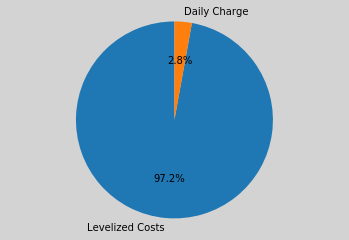

ERROR:ga_logger:panel values: (251.24362537473374, 93.73874051387912, 114.93617095973802, 1.5288454944924843, 2.3282629598656515, 54.74810210267808, 0.8882742462318551, 0.8485633994649915, 0.8818905462028646)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 251
                                           a tilt of 1.5
                                           and a gcr of 0.888


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.152660369873047 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 94
                                           a tilt of 2.3
                                           and a gcr of 0.849


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.218360662460327 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 54.7
                                           and a gcr of 0.882


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3762664794921875 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 204 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [335.27735385984573, 0.0, 0.0]


ERROR:ga_logger:Cost: 3463.098149444812


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


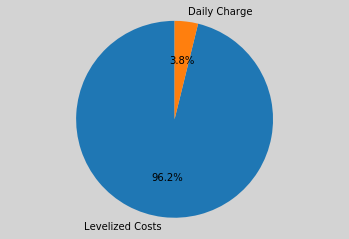

ERROR:ga_logger:panel values: (100.8704237661361, 95.00768166165834, 240.68406369756025, 40.141723184822915, 1.546802220681647, 14.019485229127262, 0.8821782694154137, 0.7345535502875076, 0.5674920487070008)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 101
                                           a tilt of 40.1
                                           and a gcr of 0.882


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.313436508178711 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 1.5
                                           and a gcr of 0.735


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1934454441070557 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 241
                                           a tilt of 14.0
                                           and a gcr of 0.567


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4375979900360107 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 203 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 326.29700256336804]


ERROR:ga_logger:Cost: 3373.9035115396982


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


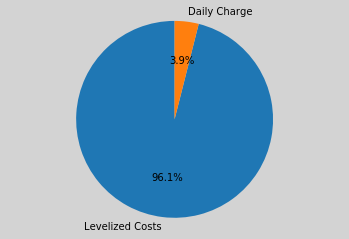

ERROR:ga_logger:panel values: (174.74677738647438, 189.32378439887447, 173.2356076745716, 21.530862758243742, 30.15921441995381, 30.43049564342483, 0.6596454263228662, 0.7524534688215154, 0.4374148680870912)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 21.5
                                           and a gcr of 0.660


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.347848415374756 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 189
                                           a tilt of 30.2
                                           and a gcr of 0.752


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3531107902526855 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 173
                                           a tilt of 30.4
                                           and a gcr of 0.437


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.371887445449829 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 197 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [104.30184741949424, 0.0, 192.74407652322586]


ERROR:ga_logger:Cost: 3083.3759681896945


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


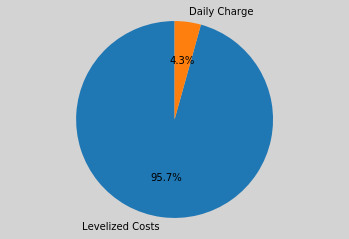

ERROR:ga_logger:panel values: (167.40426877739444, 187.21422743838355, 179.1292134985777, 21.98298871924151, 30.18972072857112, 29.75798719429025, 0.6835698576972475, 0.6678878084965402, 0.4763621823414431)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 22.0
                                           and a gcr of 0.684


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3000521659851074 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 187
                                           a tilt of 30.2
                                           and a gcr of 0.668


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.300868034362793 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 179
                                           a tilt of 29.8
                                           and a gcr of 0.476


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.292363405227661 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 206 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 36.16918566697786, 259.43022587366465]


ERROR:ga_logger:Cost: 3069.008920016011


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


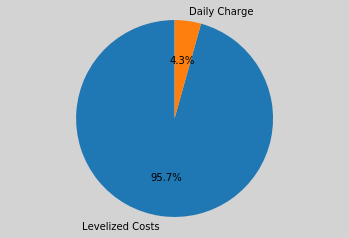

ERROR:ga_logger:panel values: (167.42492058497163, 191.38983966358802, 181.93699510318805, 22.65714043417341, 30.11570188888217, 29.93998867490701, 0.6832894527297875, 0.6724238063615166, 0.49157073362453807)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 22.7
                                           and a gcr of 0.683


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.31689453125 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 191
                                           a tilt of 30.1
                                           and a gcr of 0.672


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3719308376312256 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 182
                                           a tilt of 29.9
                                           and a gcr of 0.492


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4250786304473877 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 216 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 294.185534315766]


ERROR:ga_logger:Cost: 3054.9660089998492


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


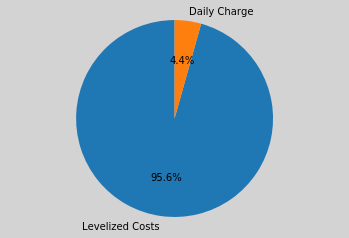

ERROR:ga_logger:panel values: (218.2248001018308, 243.6397169032592, 263.157581857179, 1.029379514255103, 4.00032610638206, 53.67261499936815, 0.8942742603886062, 0.8977323395260319, 0.882541989698828)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 218
                                           a tilt of 1.0
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4204301834106445 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 244
                                           a tilt of 4.0
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.369370698928833 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 263
                                           a tilt of 53.7
                                           and a gcr of 0.883


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.30934739112854 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 217 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [334.0595540784414, 0.0, 0.0]


ERROR:ga_logger:Cost: 3451.002718740831


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


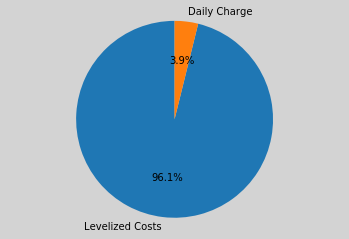

ERROR:ga_logger:panel values: (246.7331976837029, 174.43447814016244, 208.39011596293818, 3.907312447546484, 55.89457420634915, 49.91455769557329, 0.8858310647862897, 0.8804617090146698, 0.8316994659080865)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 247
                                           a tilt of 3.9
                                           and a gcr of 0.886


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3535499572753906 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 174
                                           a tilt of 55.9
                                           and a gcr of 0.880


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.437260150909424 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 208
                                           a tilt of 49.9
                                           and a gcr of 0.832


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.460577964782715 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 210 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [334.40717697127945, 0.0, 0.0]


ERROR:ga_logger:Cost: 3454.4553795791767


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


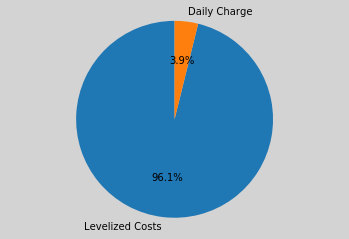

ERROR:ga_logger:panel values: (229.35167769806995, 263.25139117641925, 139.98648943744575, 1.9153492755497816, 5.851302383424497, 40.54655091723021, 0.8985688411230428, 0.8816776132464135, 0.39632340744573474)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 229
                                           a tilt of 1.9
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2167539596557617 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 263
                                           a tilt of 5.9
                                           and a gcr of 0.882


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4726405143737793 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 40.5
                                           and a gcr of 0.396


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6672537326812744 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 194 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [149.6483342480916, 0.0, 171.29926977937205]


ERROR:ga_logger:Cost: 3320.7722248160494


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


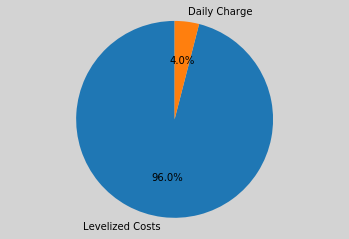

ERROR:ga_logger:panel values: (139.1050405686249, 182.7911875809608, 198.64138541339742, 20.475260989478357, 24.805697403010868, 27.622936315232177, 0.6245808849240471, 0.6732994256036744, 0.541318682303846)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 139
                                           a tilt of 20.5
                                           and a gcr of 0.625


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3157899379730225 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 24.8
                                           and a gcr of 0.673


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.344215154647827 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 199
                                           a tilt of 27.6
                                           and a gcr of 0.541


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6397554874420166 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 204 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 300.2684703463442]


ERROR:ga_logger:Cost: 3115.3829432602142


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


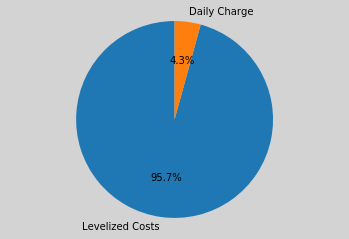

ERROR:ga_logger:panel values: (166.53325863553786, 178.18047391644626, 181.64970670886777, 25.633414533862926, 25.028424736633774, 29.24715245316812, 0.6730555967600538, 0.6696796343798801, 0.5591635528745156)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 25.6
                                           and a gcr of 0.673


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4449706077575684 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 178
                                           a tilt of 25.0
                                           and a gcr of 0.670


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.360714912414551 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 182
                                           a tilt of 29.2
                                           and a gcr of 0.559


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.410349130630493 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 222 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 296.083829684522]


ERROR:ga_logger:Cost: 3073.820258504139


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


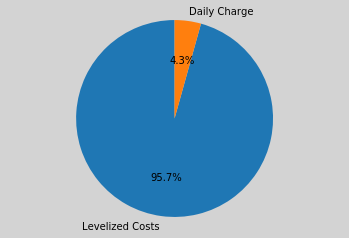

ERROR:ga_logger:panel values: (166.8040305996193, 186.626929667432, 178.17357796875433, 24.33155289990895, 27.437871945326734, 31.220486541001065, 0.6679233361730244, 0.699912607980202, 0.4892976937816521)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 24.3
                                           and a gcr of 0.668


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.340214967727661 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 187
                                           a tilt of 27.4
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3261611461639404 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 178
                                           a tilt of 31.2
                                           and a gcr of 0.489


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3635001182556152 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 209 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 7.717226406329386, 287.5777203524649]


ERROR:ga_logger:Cost: 3065.9849158604798


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


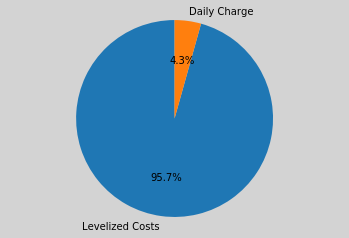

ERROR:ga_logger:panel values: (214.4376598893686, 95.67448994956182, 91.74898671777959, 54.9399293332123, 1.1081480237512678, 4.137204388198382, 0.25411596082135485, 0.8952793416647176, 0.6536423725427972)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 214
                                           a tilt of 54.9
                                           and a gcr of 0.254


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4089512825012207 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 96
                                           a tilt of 1.1
                                           and a gcr of 0.895


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.400820255279541 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 92
                                           a tilt of 4.1
                                           and a gcr of 0.654


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.428856611251831 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 200 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [80.72958742649436, 251.6394741097973, 0.0]


ERROR:ga_logger:Cost: 3434.21241663798


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


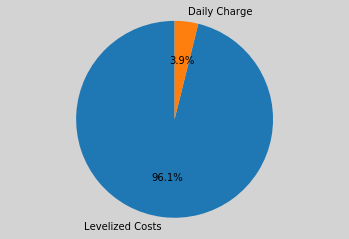

ERROR:ga_logger:panel values: (121.487340678551, 101.1676196220743, 92.14397740144041, 38.48626078420499, 2.986920551149565, 12.828991277950093, 0.721489127694015, 0.8911491467694044, 0.23021206990910392)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 121
                                           a tilt of 38.5
                                           and a gcr of 0.721


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5836501121520996 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 101
                                           a tilt of 3.0
                                           and a gcr of 0.891


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.317927837371826 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 92
                                           a tilt of 12.8
                                           and a gcr of 0.230


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4374494552612305 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 199 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 335.1063926313447, 0.0]


ERROR:ga_logger:Cost: 3461.4001288075315


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


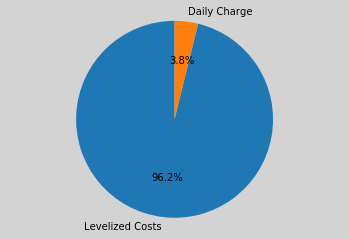

ERROR:ga_logger:panel values: (165.68546404089344, 96.92447594495866, 158.80215571952624, 41.99289269667369, 3.0005496753075276, 19.55757174494888, 0.5481400798249918, 0.8994025219778721, 0.8559295798301534)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 166
                                           a tilt of 42.0
                                           and a gcr of 0.548


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.323368549346924 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 97
                                           a tilt of 3.0
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.352801561355591 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 159
                                           a tilt of 19.6
                                           and a gcr of 0.856


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4252190589904785 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 202 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [305.687510695659, 0.0, 0.0]


ERROR:ga_logger:Cost: 3169.2059469091373


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


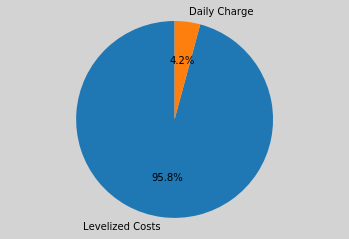

ERROR:ga_logger:panel values: (178.83996632513504, 186.73419649099026, 166.27337588453088, 18.45804746425107, 21.2213487423436, 26.18490494425101, 0.7536195245331163, 0.7780602046792027, 0.5801204793413974)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 179
                                           a tilt of 18.5
                                           and a gcr of 0.754


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.450622081756592 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 187
                                           a tilt of 21.2
                                           and a gcr of 0.778


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.442065715789795 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 166
                                           a tilt of 26.2
                                           and a gcr of 0.580


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3884758949279785 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 202 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 300.17762687773245]


ERROR:ga_logger:Cost: 3114.480667359459


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


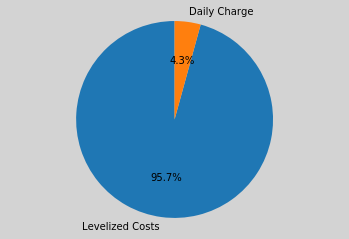

ERROR:ga_logger:panel values: (163.32143502792928, 188.07593905457406, 182.1232057006782, 24.153432839030202, 30.04514661401706, 30.68842158811647, 0.6532102139164631, 0.6727254739271498, 0.5014240477227945)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 163
                                           a tilt of 24.2
                                           and a gcr of 0.653


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.332249879837036 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 188
                                           a tilt of 30.0
                                           and a gcr of 0.673


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.392025947570801 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 182
                                           a tilt of 30.7
                                           and a gcr of 0.501


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5188918113708496 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 199 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 294.43306180884224]


ERROR:ga_logger:Cost: 3057.4245022809764


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


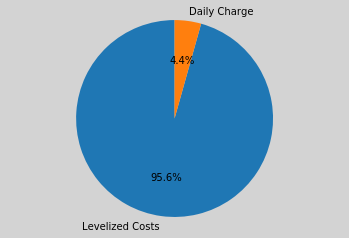

ERROR:ga_logger:panel values: (163.6248619555476, 180.4125377541711, 178.53063681653828, 24.228784248956803, 27.66084431810126, 29.55729076894502, 0.6362212038133677, 0.6347094119502676, 0.5215411144159923)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 164
                                           a tilt of 24.2
                                           and a gcr of 0.636


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4412710666656494 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 27.7
                                           and a gcr of 0.635


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4563148021698 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 179
                                           a tilt of 29.6
                                           and a gcr of 0.522


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.455627918243408 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 202 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 296.09536650518436]


ERROR:ga_logger:Cost: 3073.9348438915786


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


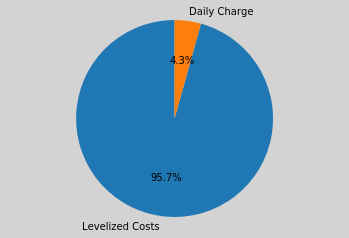

ERROR:ga_logger:panel values: (166.2317149727274, 192.21215529965173, 176.5922768996719, 23.134548760018284, 30.638270058018126, 28.13218742471166, 0.6854454531144675, 0.6744924385683115, 0.4947632342511052)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 166
                                           a tilt of 23.1
                                           and a gcr of 0.685


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.604962110519409 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 30.6
                                           and a gcr of 0.674


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.427422285079956 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 177
                                           a tilt of 28.1
                                           and a gcr of 0.495


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.418625593185425 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 187 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 295.42713283242546]


ERROR:ga_logger:Cost: 3067.297811969766


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


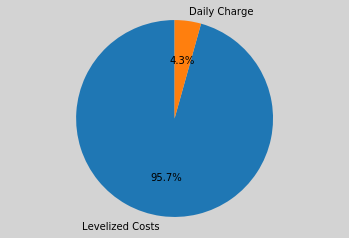

ERROR:ga_logger:panel values: (166.66829826813267, 194.0790969863789, 180.1993029944192, 22.420985689156144, 30.305331744912685, 30.020174863224838, 0.678388613786751, 0.6697517596468039, 0.479000513263648)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 22.4
                                           and a gcr of 0.678


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3684306144714355 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 194
                                           a tilt of 30.3
                                           and a gcr of 0.670


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.414022445678711 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 30.0
                                           and a gcr of 0.479


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3074240684509277 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 160 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [26.56578526114816, 0.0, 268.0494309761821]


ERROR:ga_logger:Cost: 3059.233695255509


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


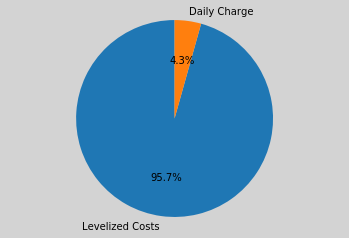

ERROR:ga_logger:panel values: (167.6687195774052, 191.8479393400267, 180.64474627383885, 22.733631215282145, 30.33170915665456, 29.86751963199942, 0.6847849274013704, 0.6609206934128091, 0.48769943249089936)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 168
                                           a tilt of 22.7
                                           and a gcr of 0.685


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3965325355529785 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 30.3
                                           and a gcr of 0.661


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.330000400543213 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 29.9
                                           and a gcr of 0.488


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3381524085998535 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 8.203327756952495, 285.962421429119]


ERROR:ga_logger:Cost: 3054.7694991327326


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


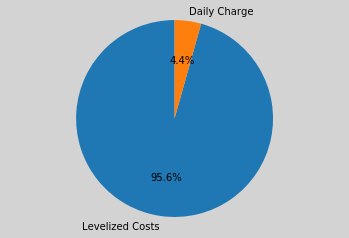

ERROR:ga_logger:panel values: (168.13519181319987, 191.96406492616444, 179.7452992414696, 22.460027801681836, 30.057981213712836, 29.989053140371503, 0.6825498573127458, 0.6659905870219187, 0.48967605178601026)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 168
                                           a tilt of 22.5
                                           and a gcr of 0.683


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.156527519226074 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 30.1
                                           and a gcr of 0.666


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.235147953033447 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 30.0
                                           and a gcr of 0.490


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9326717853546143 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 7.886398500789122, 287.40070485580054]


ERROR:ga_logger:Cost: 3065.9070127294367


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


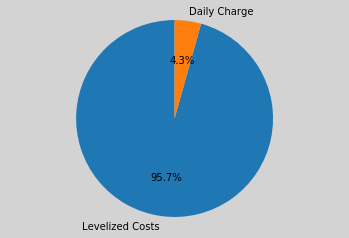

ERROR:ga_logger:panel values: (167.46272979308173, 192.0701457673772, 180.24585884335104, 22.3146416172952, 30.059166739137137, 29.857953485928473, 0.6844902119310072, 0.6652983090929587, 0.4892760309239036)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 22.3
                                           and a gcr of 0.684


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.114387512207031 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 30.1
                                           and a gcr of 0.665


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.139467000961304 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 29.9
                                           and a gcr of 0.489


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9978556632995605 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 146 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 4.015902850211385, 290.00634938775465]


ERROR:ga_logger:Cost: 3053.3442587513064


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


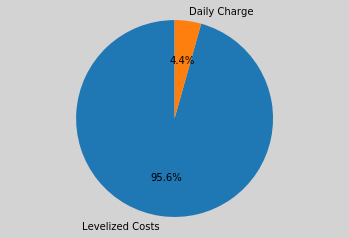

ERROR:ga_logger:panel values: (258.7213428376648, 246.96668588696414, 263.8860808926149, 55.48065140928008, 1.5193423312653467, 1.6389996485458393, 0.8925389924629623, 0.8886686692429282, 0.23155477767014593)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 259
                                           a tilt of 55.5
                                           and a gcr of 0.893


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.827198028564453 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 247
                                           a tilt of 1.5
                                           and a gcr of 0.889


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.760439157485962 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 264
                                           a tilt of 1.6
                                           and a gcr of 0.232


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7439956665039062 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  18 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 179 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 334.96245001222246, 0.0]


ERROR:ga_logger:Cost: 3459.970461541517


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


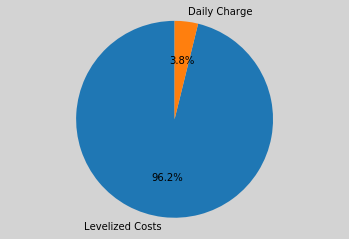

ERROR:ga_logger:panel values: (193.6746531110544, 212.8357438469111, 162.3427277382769, 53.12768267576334, 2.9961774516383164, 3.229375258881091, 0.5261656096775499, 0.8784468930514224, 0.39419459410492985)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 194
                                           a tilt of 53.1
                                           and a gcr of 0.526


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6391870975494385 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 213
                                           a tilt of 3.0
                                           and a gcr of 0.878


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.580143928527832 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 162
                                           a tilt of 3.2
                                           and a gcr of 0.394


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.551086902618408 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 191 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [309.42545766273764, 9.386652195990575, 0.0]


ERROR:ga_logger:Cost: 3299.5621122295006


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


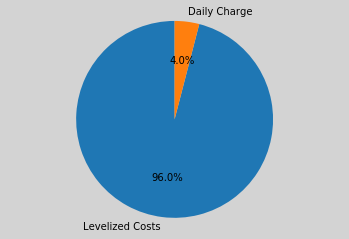

ERROR:ga_logger:panel values: (205.1122393729823, 182.03180140581622, 201.67802500643847, 54.241073482606815, 2.073538624569461, 41.915807171385374, 0.8965253638701463, 0.8951421313027303, 0.33197431666434307)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 54.2
                                           and a gcr of 0.897


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4023220539093018 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 2.1
                                           and a gcr of 0.895


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2689645290374756 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 202
                                           a tilt of 41.9
                                           and a gcr of 0.332


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5884499549865723 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 191 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 188.648997796467, 128.81073097883427]


ERROR:ga_logger:Cost: 3286.129948907113


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


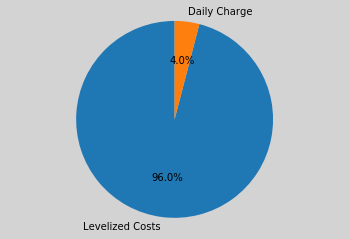

ERROR:ga_logger:panel values: (157.17128395742054, 202.98982621623628, 189.57892557665616, 24.379362002663658, 27.046721198383008, 27.125110327622163, 0.6949093636684645, 0.7608704950095551, 0.4494280245214986)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 24.4
                                           and a gcr of 0.695


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3882791996002197 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 203
                                           a tilt of 27.0
                                           and a gcr of 0.761


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4083685874938965 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 27.1
                                           and a gcr of 0.449


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4646899700164795 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 184 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [84.59629258012065, 0.0, 214.38818807978217]


ERROR:ga_logger:Cost: 3102.630100054307


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


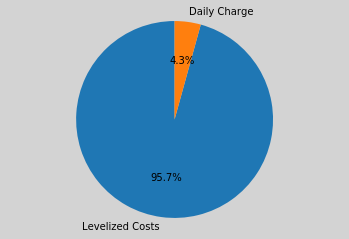

ERROR:ga_logger:panel values: (163.94296613966395, 187.28846499902693, 186.02331037120206, 23.156316848531457, 29.53322073148786, 30.112408028019868, 0.6812360716911013, 0.6631816325272284, 0.5088227123501811)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 164
                                           a tilt of 23.2
                                           and a gcr of 0.681


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3002610206604004 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 187
                                           a tilt of 29.5
                                           and a gcr of 0.663


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3040242195129395 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 186
                                           a tilt of 30.1
                                           and a gcr of 0.509


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3792788982391357 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 191 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 295.39370648860177]


ERROR:ga_logger:Cost: 3066.965816732932


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


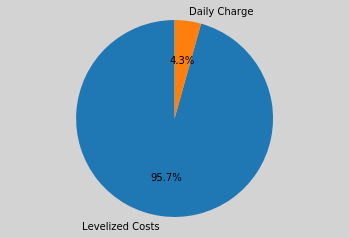

ERROR:ga_logger:panel values: (166.636665549338, 191.8457273567395, 180.95994311864607, 22.47690494851037, 30.010185176938236, 29.813494260681864, 0.6846288200015804, 0.6653465786953536, 0.48843841972912555)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 22.5
                                           and a gcr of 0.685


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.270773410797119 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 30.0
                                           and a gcr of 0.665


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.316556692123413 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 29.8
                                           and a gcr of 0.488


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3158774375915527 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 191 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 6.474643412913571, 287.705100672083]


ERROR:ga_logger:Cost: 3054.908499206077


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


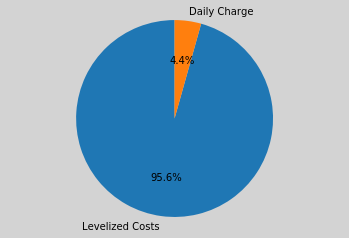

ERROR:ga_logger:panel values: (262.22237504662917, 256.27328683282974, 188.45722247058842, 51.904952120469964, 42.09501555039829, 9.379641969593553, 0.8843630287533399, 0.8984428131949962, 0.8360751795760093)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 51.9
                                           and a gcr of 0.884


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2996037006378174 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 256
                                           a tilt of 42.1
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3466715812683105 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 188
                                           a tilt of 9.4
                                           and a gcr of 0.836


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5143299102783203 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 205 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 318.3340579460971]


ERROR:ga_logger:Cost: 3294.813956492787


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


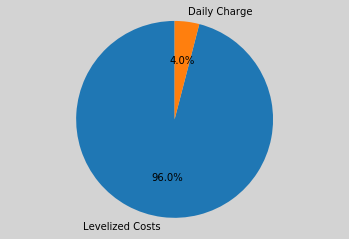

ERROR:ga_logger:panel values: (216.10462021932523, 120.38295521818507, 105.731366438821, 54.6834096085402, 37.77243482241031, 2.630617706999816, 0.8555396585983162, 0.8612365612176593, 0.8939451000587295)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 216
                                           a tilt of 54.7
                                           and a gcr of 0.856


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2857472896575928 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 37.8
                                           and a gcr of 0.861


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2835187911987305 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 106
                                           a tilt of 2.6
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1855762004852295 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 210 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 334.4838285816045]


ERROR:ga_logger:Cost: 3455.216698222031


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


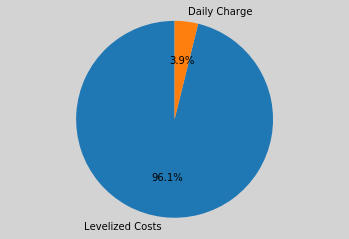

ERROR:ga_logger:panel values: (193.03915391310673, 169.35756101435533, 170.90610155098858, 47.063521964349626, 1.291869312718413, 7.9567340530560635, 0.8942231411539887, 0.5360228164457578, 0.6990002579262968)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 193
                                           a tilt of 47.1
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.322814464569092 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 169
                                           a tilt of 1.3
                                           and a gcr of 0.536


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.165928602218628 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 171
                                           a tilt of 8.0
                                           and a gcr of 0.699


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2858667373657227 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 212 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 317.31036944779595]


ERROR:ga_logger:Cost: 3284.6464754678846


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


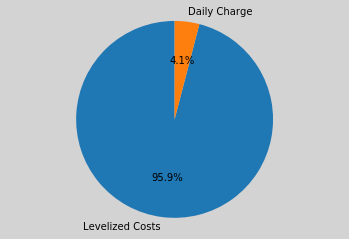

ERROR:ga_logger:panel values: (167.1886664873452, 181.27738670432578, 176.89670285558248, 29.033854999129645, 21.560336142140212, 26.89990881813664, 0.5712879736694851, 0.7175941495923508, 0.4897618467965731)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 29.0
                                           and a gcr of 0.571


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3120105266571045 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 181
                                           a tilt of 21.6
                                           and a gcr of 0.718


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.92471981048584 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 177
                                           a tilt of 26.9
                                           and a gcr of 0.490


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.33841872215271 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 220 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [0.0, 7.891594082942836, 287.8645715774079]


ERROR:ga_logger:Cost: 3070.5658306997916


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


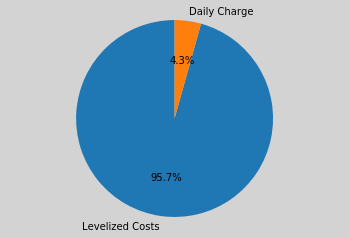

ERROR:ga_logger:panel values: (165.2227539664932, 181.09130784570067, 178.93059008582992, 27.185196551853824, 24.541312140907287, 28.99927894235051, 0.6110945990232928, 0.6873773850678092, 0.5199288862337159)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 27.2
                                           and a gcr of 0.611


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.321943759918213 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 181
                                           a tilt of 24.5
                                           and a gcr of 0.687


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.369356870651245 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 179
                                           a tilt of 29.0
                                           and a gcr of 0.520


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.370507001876831 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 213 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 296.0545125168279]


ERROR:ga_logger:Cost: 3073.529073441374


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


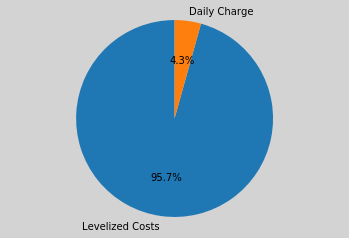

ERROR:ga_logger:panel values: (159.66689882382872, 190.24717738207232, 181.76597178570236, 23.772994314357224, 29.037976905122918, 30.496891298594274, 0.6522495098836887, 0.674300481555244, 0.4822527373146798)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 23.8
                                           and a gcr of 0.652


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3130125999450684 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 29.0
                                           and a gcr of 0.674


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3377180099487305 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 182
                                           a tilt of 30.5
                                           and a gcr of 0.482


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3588826656341553 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 200 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 20.29088240798158, 274.242630301907]


ERROR:ga_logger:Cost: 3058.422200365515


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


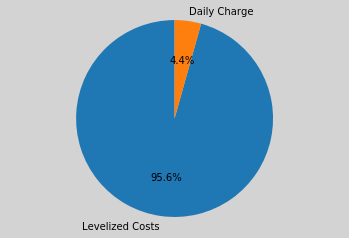

ERROR:ga_logger:panel values: (261.4142982226542, 264.9369179231097, 93.81265511044825, 5.112435553447053, 54.803089190099016, 9.242158051813416, 0.8978774940305179, 0.8800425643390786, 0.6218848211353812)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 261
                                           a tilt of 5.1
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3507022857666016 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 54.8
                                           and a gcr of 0.880


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.297593832015991 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 94
                                           a tilt of 9.2
                                           and a gcr of 0.622


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2979254722595215 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 205 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 336.06849513821015]


ERROR:ga_logger:Cost: 3470.9559240361787


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


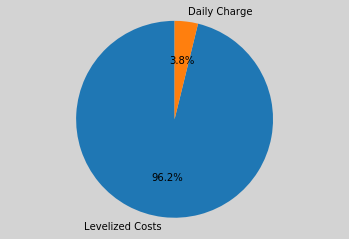

ERROR:ga_logger:panel values: (92.2841179931428, 100.291630457775, 107.3809701637353, 10.692227791802248, 2.577966993380471, 1.3094386603028547, 0.7336364563043016, 0.4974758627638571, 0.7775770702668048)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 10.7
                                           and a gcr of 0.734


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2823784351348877 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 2.6
                                           and a gcr of 0.497


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3014373779296875 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 107
                                           a tilt of 1.3
                                           and a gcr of 0.778


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.193680763244629 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 215 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 233.32999119764543, 100.87811979545549]


ERROR:ga_logger:Cost: 3452.4782156836236


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


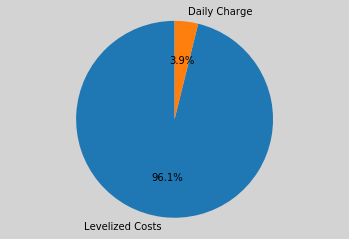

ERROR:ga_logger:panel values: (96.49486605429553, 151.85169609780115, 139.7508300132606, 18.18364706889202, 2.5563933798291685, 13.81135905001135, 0.47026442986778677, 0.8971264409317525, 0.6339339652273611)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 96
                                           a tilt of 18.2
                                           and a gcr of 0.470


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2833614349365234 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 152
                                           a tilt of 2.6
                                           and a gcr of 0.897


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.298487424850464 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 13.8
                                           and a gcr of 0.634


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3464393615722656 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 219 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 315.0992642172336]


ERROR:ga_logger:Cost: 3262.685339611353


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


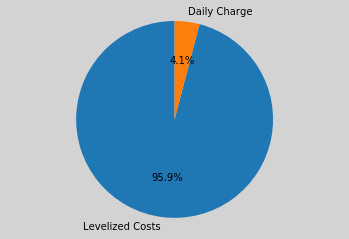

ERROR:ga_logger:panel values: (158.32768029495696, 165.38229992407952, 176.7513690118245, 28.10486817951911, 23.70980021823673, 31.568396607685376, 0.5675315667126442, 0.6110815370318694, 0.507318378467442)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 158
                                           a tilt of 28.1
                                           and a gcr of 0.568


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3566062450408936 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 23.7
                                           and a gcr of 0.611


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.28110933303833 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 177
                                           a tilt of 31.6
                                           and a gcr of 0.507


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5382802486419678 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 220 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 295.78037469144147]


ERROR:ga_logger:Cost: 3070.8062836209124


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


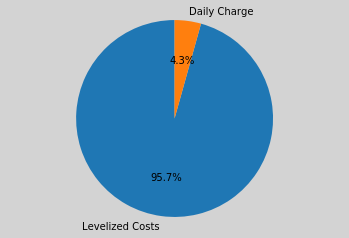

ERROR:ga_logger:panel values: (162.39949642982018, 171.65776066139338, 180.97439100603296, 27.10014054709362, 23.712592883463927, 29.347710320912515, 0.6140252879200127, 0.6004477724247219, 0.5503722012228114)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 162
                                           a tilt of 27.1
                                           and a gcr of 0.614


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3299343585968018 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 172
                                           a tilt of 23.7
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.373483896255493 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 29.3
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.375310182571411 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 210 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 295.6819524861535]


ERROR:ga_logger:Cost: 3069.828733816665


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


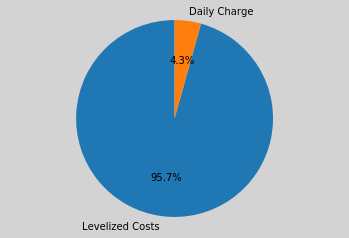

ERROR:ga_logger:panel values: (163.85190204427965, 192.4803786941062, 183.62862075160103, 22.173610168668727, 29.79507030541792, 30.53517999954542, 0.6780798999343947, 0.666148843385117, 0.4805726252446987)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 164
                                           a tilt of 22.2
                                           and a gcr of 0.678


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3004727363586426 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 29.8
                                           and a gcr of 0.666


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3512887954711914 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 184
                                           a tilt of 30.5
                                           and a gcr of 0.481


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4107744693756104 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 211 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 26.022163168363655, 268.975582557847]


ERROR:ga_logger:Cost: 3063.0330554728725


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


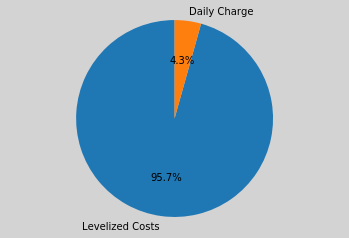

ERROR:ga_logger:panel values: (167.13018937898053, 192.05123573500896, 179.3219140874579, 22.57009070109507, 30.18750965018026, 29.42398776957022, 0.6836476133573064, 0.6674103772606723, 0.4905333688483363)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 22.6
                                           and a gcr of 0.684


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4067814350128174 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 30.2
                                           and a gcr of 0.667


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.37229061126709 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 179
                                           a tilt of 29.4
                                           and a gcr of 0.491


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3882031440734863 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 194 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 5.923089229426245, 289.35923168826525]


ERROR:ga_logger:Cost: 3065.859512148006


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


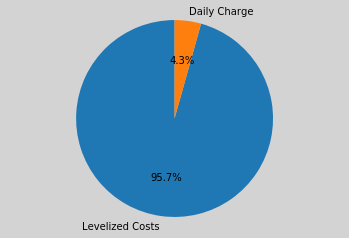

ERROR:ga_logger:panel values: (166.95129332795295, 191.72477378394078, 179.95911876252254, 22.33193731528749, 30.204241899534267, 29.998864903481955, 0.682521449220707, 0.6650853901511824, 0.4904537246392436)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 22.3
                                           and a gcr of 0.683


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.321664810180664 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 30.2
                                           and a gcr of 0.665


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.331977367401123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 30.0
                                           and a gcr of 0.490


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3480072021484375 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 197 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 6.069379307363978, 289.18915609976597]


ERROR:ga_logger:Cost: 3065.623270150948


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


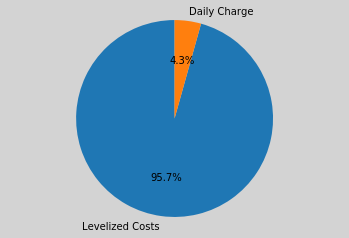

ERROR:ga_logger:panel values: (167.53657901295418, 191.66458720379364, 180.24096244977358, 22.374010559071976, 29.979259899390293, 29.830153432677353, 0.683384530752549, 0.6643978042286258, 0.490411201984346)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 168
                                           a tilt of 22.4
                                           and a gcr of 0.683


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.287663221359253 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 30.0
                                           and a gcr of 0.664


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3088698387145996 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 29.8
                                           and a gcr of 0.490


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3025362491607666 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 204 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 1.222277061631864, 292.7372377798787]


ERROR:ga_logger:Cost: 3052.7211383628314


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


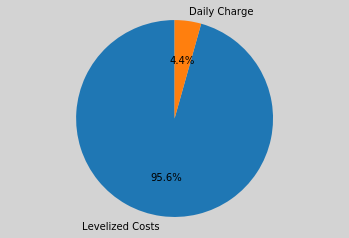

ERROR:ga_logger:panel values: (167.4275791559482, 192.12128012134383, 180.2290883444361, 22.400755738744653, 30.019619066717475, 29.86853438511862, 0.6828638934109006, 0.664867772653424, 0.4899688712993459)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 22.4
                                           and a gcr of 0.683


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3481032848358154 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 30.0
                                           and a gcr of 0.665


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3477120399475098 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 29.9
                                           and a gcr of 0.490


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.416940927505493 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 199 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 2.3000725850287473, 291.6795654107975]


ERROR:ga_logger:Cost: 3052.9210055862404


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


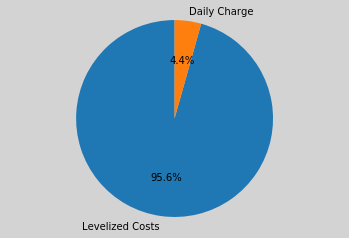

ERROR:ga_logger:panel values: (104.96888240996765, 159.92377279227674, 261.1055956042826, 38.35740612133916, 3.1222707490680226, 55.526271287068916, 0.21304170483551563, 0.8989224861348062, 0.8762255290693701)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 38.4
                                           and a gcr of 0.213


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.511754274368286 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 3.1
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3276329040527344 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 261
                                           a tilt of 55.5
                                           and a gcr of 0.876


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.374934196472168 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 205 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 329.07381602963585, 0.0]


ERROR:ga_logger:Cost: 3401.483373675189


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


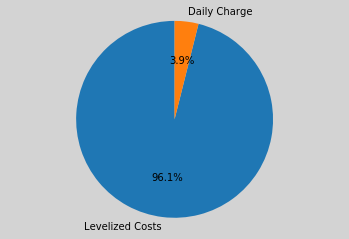

ERROR:ga_logger:panel values: (191.21288901105697, 226.24269004725875, 230.6771243431241, 51.386332515407986, 25.52026420340214, 49.72348971487546, 0.8281738428785923, 0.896430141024738, 0.8783491711635036)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 191
                                           a tilt of 51.4
                                           and a gcr of 0.828


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2438628673553467 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 226
                                           a tilt of 25.5
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.263144016265869 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 231
                                           a tilt of 49.7
                                           and a gcr of 0.878


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.339810371398926 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 214 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [337.6584601193195, 0.0, 0.0]


ERROR:ga_logger:Cost: 3486.7478289377736


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


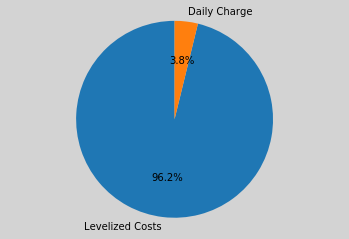

ERROR:ga_logger:panel values: (150.26221337116266, 193.7756844019187, 251.7729358820058, 48.711474491105385, 1.80682811889491, 23.017272106527503, 0.6069581544369289, 0.864613499649558, 0.7558475972765528)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 48.7
                                           and a gcr of 0.607


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2934207916259766 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 194
                                           a tilt of 1.8
                                           and a gcr of 0.865


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.150482416152954 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 252
                                           a tilt of 23.0
                                           and a gcr of 0.756


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3279483318328857 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 217 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [328.9247522496876, 0.0, 0.0]


ERROR:ga_logger:Cost: 3400.0028790537094


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


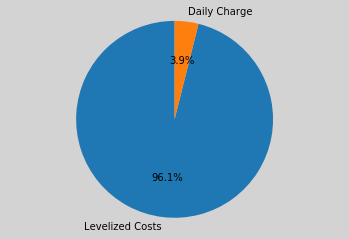

ERROR:ga_logger:panel values: (182.6983271478205, 178.58767583223351, 169.6317285382602, 29.08304276773979, 21.31515131450705, 22.699286071105114, 0.6914135682244782, 0.7606080156530755, 0.5394290398820842)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 183
                                           a tilt of 29.1
                                           and a gcr of 0.691


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.300828695297241 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 179
                                           a tilt of 21.3
                                           and a gcr of 0.761


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.303271770477295 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 22.7
                                           and a gcr of 0.539


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.331129312515259 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 221 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 299.06278840621565]


ERROR:ga_logger:Cost: 3103.4078656429033


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


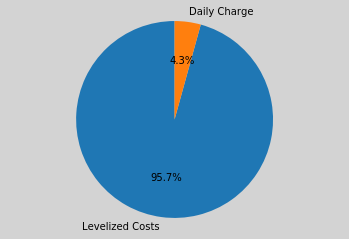

ERROR:ga_logger:panel values: (155.47838735824178, 173.4878011730798, 181.14631607541753, 25.750862103699824, 26.187421127828003, 31.285861859586028, 0.5908802999075053, 0.6492712815855668, 0.5107235216055923)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 25.8
                                           and a gcr of 0.591


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.323647975921631 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 173
                                           a tilt of 26.2
                                           and a gcr of 0.649


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2906274795532227 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 31.3
                                           and a gcr of 0.511


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4564268589019775 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 215 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 294.5332334866713]


ERROR:ga_logger:Cost: 3058.4194280716074


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


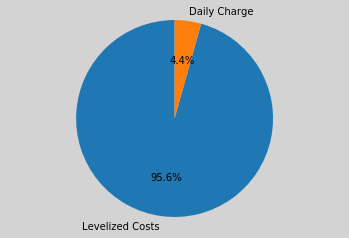

ERROR:ga_logger:panel values: (167.4548967049536, 191.9547245543062, 180.52624891719074, 22.39576732033069, 29.951520682618398, 29.82253027057318, 0.6838733246449928, 0.6645387151033473, 0.48949969230023327)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 22.4
                                           and a gcr of 0.684


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3034424781799316 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 30.0
                                           and a gcr of 0.665


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2968780994415283 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 29.8
                                           and a gcr of 0.489


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3629989624023438 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 218 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 3.647271309519469, 290.40707604711]


ERROR:ga_logger:Cost: 3053.663033848206


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


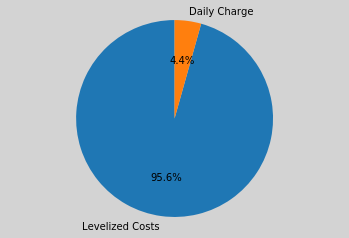

ERROR:ga_logger:panel values: (263.38172932262137, 164.39931186230953, 91.83050893693866, 26.785961717132423, 4.937911727577944, 54.12302920390057, 0.20854830842654226, 0.8950064302880023, 0.8979798390182165)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 263
                                           a tilt of 26.8
                                           and a gcr of 0.209


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4701569080352783 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 164
                                           a tilt of 4.9
                                           and a gcr of 0.895


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3081607818603516 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 92
                                           a tilt of 54.1
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3323657512664795 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 211 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 326.30736702734004, 0.0]


ERROR:ga_logger:Cost: 3374.0064512129834


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


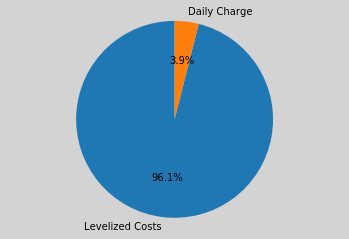

ERROR:ga_logger:panel values: (222.697381001818, 96.2092687336712, 257.0196871670754, 20.72728101659847, 4.79298603947509, 55.73452766216334, 0.6003349807416974, 0.8987478415835839, 0.7861423319601335)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 223
                                           a tilt of 20.7
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4987573623657227 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 96
                                           a tilt of 4.8
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4800517559051514 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 257
                                           a tilt of 55.7
                                           and a gcr of 0.786


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.547764539718628 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 195 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [315.52929813278496, 0.0, 0.0]


ERROR:ga_logger:Cost: 3266.956526921868


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


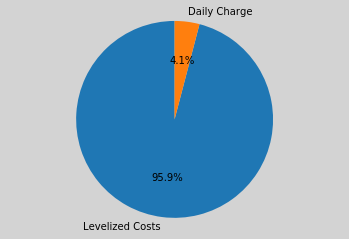

ERROR:ga_logger:panel values: (255.37898532377352, 137.23191155711768, 92.71122340909623, 31.470954965936045, 3.070167437237677, 34.70824051635888, 0.6641333083732404, 0.8942564765282159, 0.7251613614922017)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 31.5
                                           and a gcr of 0.664


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3614108562469482 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 137
                                           a tilt of 3.1
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3392088413238525 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 93
                                           a tilt of 34.7
                                           and a gcr of 0.725


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.374006509780884 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 189 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [0.0, 330.632553838473, 0.0]


ERROR:ga_logger:Cost: 3416.9650686166688


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


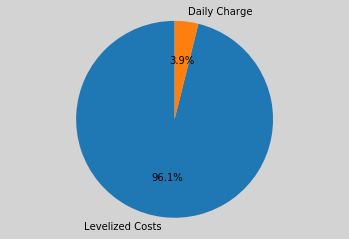

ERROR:ga_logger:panel values: (152.0309216180468, 182.91558435188068, 177.02259996611366, 20.991250223270768, 21.822763639224263, 29.538139099465585, 0.5878423773511796, 0.7768664763693849, 0.49355087788688246)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 152
                                           a tilt of 21.0
                                           and a gcr of 0.588


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.451633930206299 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 21.8
                                           and a gcr of 0.777


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3537862300872803 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 177
                                           a tilt of 29.5
                                           and a gcr of 0.494


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3521840572357178 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 196 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 295.2331969010743]


ERROR:ga_logger:Cost: 3065.371602645441


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


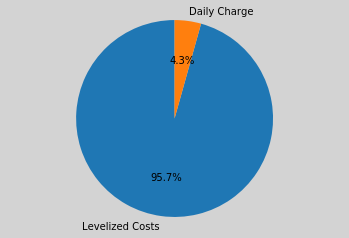

ERROR:ga_logger:panel values: (158.43055609536083, 181.60056477135268, 181.7156068300145, 23.778535523473735, 27.98871172451406, 31.970368379834674, 0.603003534630377, 0.6932117428049686, 0.4946285657297124)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 158
                                           a tilt of 23.8
                                           and a gcr of 0.603


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.35832953453064 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 28.0
                                           and a gcr of 0.693


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5818417072296143 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 182
                                           a tilt of 32.0
                                           and a gcr of 0.495


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4077365398406982 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 191 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 294.21887693220805]


ERROR:ga_logger:Cost: 3055.2971762088064


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


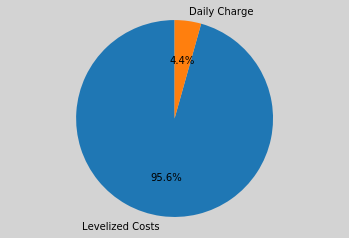

ERROR:ga_logger:panel values: (157.42105444223935, 185.53894586275737, 181.1741852566878, 23.683067565613293, 27.804887005456017, 31.295182262259644, 0.6191588314201819, 0.6907826562908475, 0.48377652730729304)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 23.7
                                           and a gcr of 0.619


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4570157527923584 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 186
                                           a tilt of 27.8
                                           and a gcr of 0.691


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.444251298904419 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 31.3
                                           and a gcr of 0.484


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4503440856933594 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 176 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 15.40341715911443, 278.8793558431639]


ERROR:ga_logger:Cost: 3055.9318040646663


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


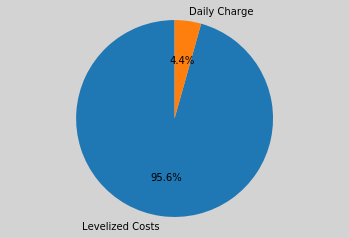

ERROR:ga_logger:panel values: (96.877277177206, 110.4318705888779, 98.94952046618458, 47.59083933949234, 43.833577908168266, 54.49507728555906, 0.22918593706946283, 0.8983997088131848, 0.8870930612135461)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 97
                                           a tilt of 47.6
                                           and a gcr of 0.229


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3721678256988525 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 43.8
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.380194902420044 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 99
                                           a tilt of 54.5
                                           and a gcr of 0.887


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4194583892822266 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 172 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [40.7169604854472, 378.31846307349105, 0.0]


ERROR:ga_logger:Cost: 4295.000067551147


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


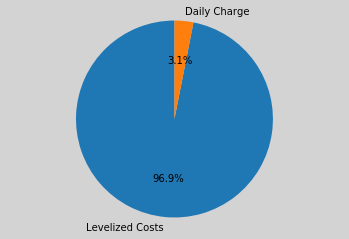

ERROR:ga_logger:panel values: (220.80628086079386, 256.6563327759892, 121.66840741145849, 23.456243954317287, 5.2958214388757865, 1.783657911538815, 0.8873912631423944, 0.8782490873900304, 0.4522340456302929)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 221
                                           a tilt of 23.5
                                           and a gcr of 0.887


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.512845039367676 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 257
                                           a tilt of 5.3
                                           and a gcr of 0.878


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4044289588928223 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 122
                                           a tilt of 1.8
                                           and a gcr of 0.452


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3016016483306885 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  19 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 173 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 131.73126937159947, 202.9484484331504]


ERROR:ga_logger:Cost: 3457.162309266838


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


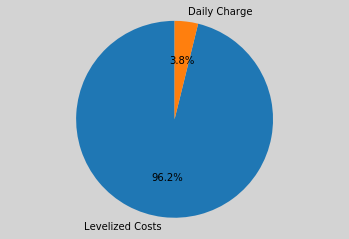

ERROR:ga_logger:panel values: (211.41605568087544, 142.91257416512659, 236.1320143636122, 25.77866368669236, 20.929752806535674, 32.775522747273556, 0.8914631181143033, 0.8834262800618522, 0.8770717228996034)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 211
                                           a tilt of 25.8
                                           and a gcr of 0.891


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7279295921325684 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 143
                                           a tilt of 20.9
                                           and a gcr of 0.883


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5065839290618896 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 236
                                           a tilt of 32.8
                                           and a gcr of 0.877


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5524165630340576 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 177 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 331.921033923633, 0.0]


ERROR:ga_logger:Cost: 3429.762527693602


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


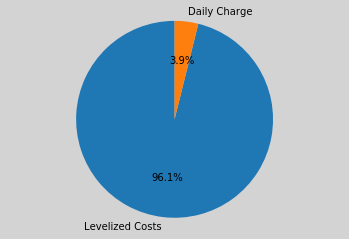

ERROR:ga_logger:panel values: (157.6934074358146, 173.03164532212716, 171.33682939794295, 20.85493135896662, 20.969356770609515, 31.137187167424994, 0.6355471644002055, 0.6852818893954515, 0.49548546961791107)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 158
                                           a tilt of 20.9
                                           and a gcr of 0.636


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.387753486633301 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 173
                                           a tilt of 21.0
                                           and a gcr of 0.685


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4035720825195312 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 171
                                           a tilt of 31.1
                                           and a gcr of 0.495


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4558207988739014 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 179 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 295.9193615294551]


ERROR:ga_logger:Cost: 3072.186727995831


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


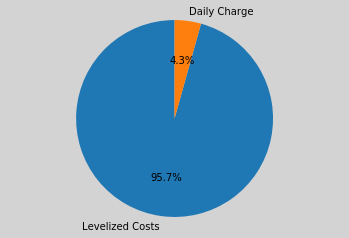

ERROR:ga_logger:panel values: (158.0610875255074, 182.97515126951797, 180.99025526105947, 23.437120348464106, 27.093765088024952, 32.63089271075236, 0.6207392003716575, 0.7019673370556176, 0.48644080127670264)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 158
                                           a tilt of 23.4
                                           and a gcr of 0.621


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.255389928817749 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 27.1
                                           and a gcr of 0.702


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.271993637084961 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 32.6
                                           and a gcr of 0.486


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2981159687042236 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 195 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 9.64504754781459, 284.57840403618593]


ERROR:ga_logger:Cost: 3055.3426129368854


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


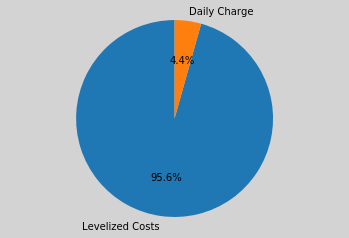

ERROR:ga_logger:panel values: (158.68699015449675, 179.80917653225075, 180.73614515121614, 24.69401637155114, 26.722017526835, 31.89500035085959, 0.610204464380024, 0.6881111473065213, 0.4891393395199536)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 159
                                           a tilt of 24.7
                                           and a gcr of 0.610


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2941675186157227 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 26.7
                                           and a gcr of 0.688


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.369751214981079 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 31.9
                                           and a gcr of 0.489


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.419496774673462 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 204 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 4.023570881726696, 290.0177640353895]


ERROR:ga_logger:Cost: 3053.533793290107


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


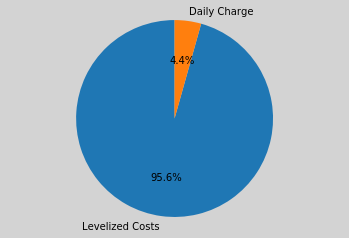

ERROR:ga_logger:panel values: (167.223375782189, 191.86595967472238, 179.54144934617196, 22.426277000231167, 29.908077177920955, 29.610572490753732, 0.684139371928346, 0.6633654405337839, 0.4898034230405363)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 22.4
                                           and a gcr of 0.684


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.364811658859253 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 29.9
                                           and a gcr of 0.663


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2805733680725098 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 29.6
                                           and a gcr of 0.490


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3132801055908203 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 219 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 7.716229804423253, 287.57815492927375]


ERROR:ga_logger:Cost: 3065.979332525843


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


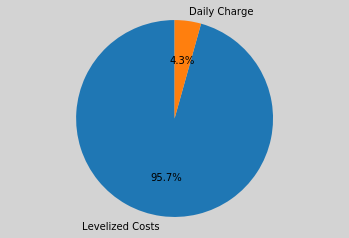

ERROR:ga_logger:panel values: (167.49416939640128, 191.6773994148438, 180.3170409932151, 22.304387122823545, 29.921617644288343, 29.780345743956026, 0.6827737372528913, 0.6660353243408808, 0.49102573020871026)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 22.3
                                           and a gcr of 0.683


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2815468311309814 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 29.9
                                           and a gcr of 0.666


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.448608160018921 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 29.8
                                           and a gcr of 0.491


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3935885429382324 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 221 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 293.95018299235085]


ERROR:ga_logger:Cost: 3052.628452529493


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


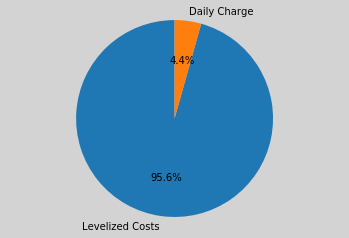

ERROR:ga_logger:panel values: (167.6204981317789, 191.67287435409116, 180.3397353751337, 22.381811191808325, 30.037151238506667, 29.77830536797843, 0.6831975412105132, 0.664358403188623, 0.49057181218261814)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 168
                                           a tilt of 22.4
                                           and a gcr of 0.683


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2939209938049316 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 30.0
                                           and a gcr of 0.664


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2861270904541016 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 29.8
                                           and a gcr of 0.491


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2770891189575195 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 224 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.9001090871708436, 293.0709494895297]


ERROR:ga_logger:Cost: 3052.8357930038733


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


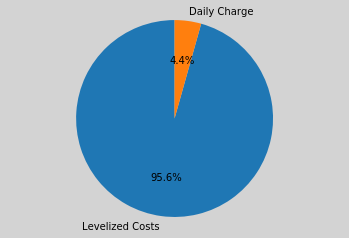

ERROR:ga_logger:panel values: (246.74271592544358, 230.11977479328368, 97.3415930924516, 5.519044313897699, 3.8159937793372136, 1.0336664827622435, 0.31601675084473857, 0.8816540967215498, 0.8649425796797048)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 247
                                           a tilt of 5.5
                                           and a gcr of 0.316


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4307861328125 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 3.8
                                           and a gcr of 0.882


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.921821355819702 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 97
                                           a tilt of 1.0
                                           and a gcr of 0.865


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4605889320373535 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 222 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 331.43095559705614, 0.0]


ERROR:ga_logger:Cost: 3424.8949546025806


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


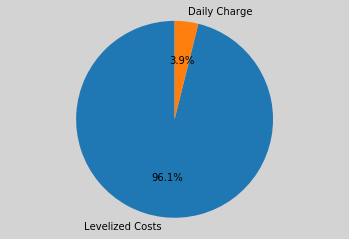

ERROR:ga_logger:panel values: (91.1816788072537, 254.19034167160686, 256.7615941556596, 1.6338783538611614, 1.621712375851318, 49.79646916191754, 0.874986626139588, 0.8963283464633438, 0.3833991866436809)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 1.6
                                           and a gcr of 0.875


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.163137674331665 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 254
                                           a tilt of 1.6
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0359230041503906 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 257
                                           a tilt of 49.8
                                           and a gcr of 0.383


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4331932067871094 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 211 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 335.50396831155007, 0.0]


ERROR:ga_logger:Cost: 3465.3489294666138


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


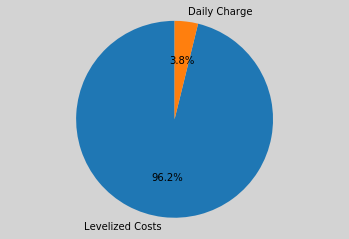

ERROR:ga_logger:panel values: (166.33728037694573, 152.91087636737748, 208.3947699950449, 9.11971928192217, 1.837623114036411, 31.440790552644913, 0.473469342955105, 0.8890728528009058, 0.8942513526991096)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 166
                                           a tilt of 9.1
                                           and a gcr of 0.473


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4371774196624756 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 153
                                           a tilt of 1.8
                                           and a gcr of 0.889


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.161890745162964 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 208
                                           a tilt of 31.4
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2800118923187256 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 201 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [244.44205873009923, 73.33352611696198, 0.0]


ERROR:ga_logger:Cost: 3289.2670868808573


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


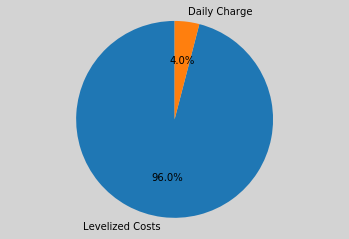

ERROR:ga_logger:panel values: (166.93492055734578, 185.74086627608395, 173.59347139940417, 22.929067092227825, 24.010356412312728, 29.991787632830142, 0.6081144439433149, 0.7429811288070491, 0.4822676746505233)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 22.9
                                           and a gcr of 0.608


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3329858779907227 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 186
                                           a tilt of 24.0
                                           and a gcr of 0.743


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2707529067993164 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 174
                                           a tilt of 30.0
                                           and a gcr of 0.482


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2985854148864746 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 191 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 20.109235347241892, 275.7105362318139]


ERROR:ga_logger:Cost: 3071.197579643296


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


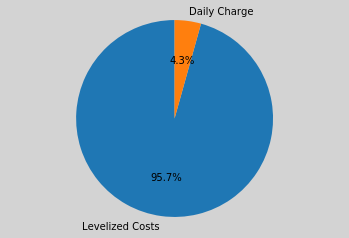

ERROR:ga_logger:panel values: (156.1732134054273, 180.39991945917592, 182.12818921828062, 23.66239294255781, 26.188463363122537, 31.343539792499705, 0.6020802802071127, 0.6864643856746973, 0.4833414262480205)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 23.7
                                           and a gcr of 0.602


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.546926736831665 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 26.2
                                           and a gcr of 0.686


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.287675142288208 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 182
                                           a tilt of 31.3
                                           and a gcr of 0.483


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3564043045043945 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 188 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 16.792588444982403, 277.58261812879175]


ERROR:ga_logger:Cost: 3056.8498726988637


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


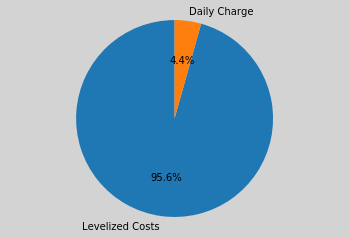

ERROR:ga_logger:panel values: (167.53196469477356, 191.77904944897267, 180.54561650880743, 22.353510320000506, 29.975143919568122, 29.813910333927208, 0.6832329083112212, 0.6653207698021504, 0.49041072593864893)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 168
                                           a tilt of 22.4
                                           and a gcr of 0.683


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.299459934234619 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 30.0
                                           and a gcr of 0.665


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.233694553375244 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 29.8
                                           and a gcr of 0.490


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2383060455322266 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 196 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 1.4012496155428087, 292.60628377156775]


ERROR:ga_logger:Cost: 3053.19806813525


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


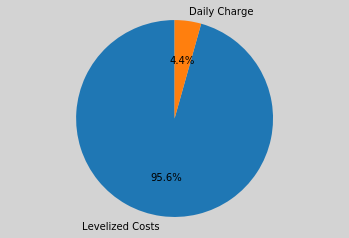

ERROR:ga_logger:panel values: (188.53499487414086, 245.45880678889483, 233.48335946402855, 3.912593470085181, 49.97937525653262, 1.8915240225337357, 0.862669081844555, 0.8913432959973271, 0.8894155575369547)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 189
                                           a tilt of 3.9
                                           and a gcr of 0.863


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4012880325317383 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 50.0
                                           and a gcr of 0.891


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4621222019195557 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 233
                                           a tilt of 1.9
                                           and a gcr of 0.889


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2662808895111084 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 212 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [326.4936859490464, 0.0, 0.0]


ERROR:ga_logger:Cost: 3375.857006925495


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


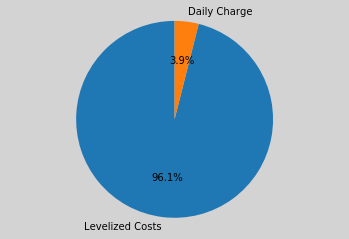

ERROR:ga_logger:panel values: (261.7882278728417, 253.27712349247815, 167.75260891636606, 12.533579290565545, 23.79566546748833, 15.013931832172965, 0.8942332244358704, 0.89799175194647, 0.8293996818568901)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 12.5
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5004379749298096 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 253
                                           a tilt of 23.8
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3078155517578125 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 168
                                           a tilt of 15.0
                                           and a gcr of 0.829


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2938733100891113 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 212 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 315.6288814226616]


ERROR:ga_logger:Cost: 3267.9456082960687


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


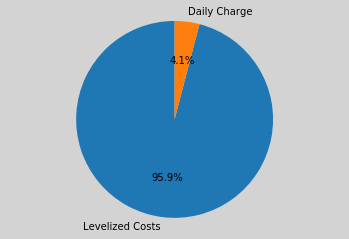

ERROR:ga_logger:panel values: (149.56842226763416, 113.02431388908057, 192.7330049909823, 27.254435548079265, 12.412807717147246, 18.86288344560257, 0.8968992572627354, 0.5724519030940827, 0.8704765740922564)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 27.3
                                           and a gcr of 0.897


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.376314878463745 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 113
                                           a tilt of 12.4
                                           and a gcr of 0.572


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.287745714187622 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 193
                                           a tilt of 18.9
                                           and a gcr of 0.870


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3538224697113037 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 214 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 317.9742192704161]


ERROR:ga_logger:Cost: 3291.239977470337


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


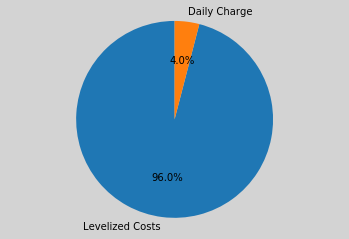

ERROR:ga_logger:panel values: (152.38193090254242, 181.79634411650835, 177.6986833956792, 24.474201928913082, 23.156619925453153, 27.37485646934984, 0.593332067838005, 0.7193362797304179, 0.5011300120057969)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 152
                                           a tilt of 24.5
                                           and a gcr of 0.593


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.361222267150879 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 23.2
                                           and a gcr of 0.719


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2561607360839844 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 178
                                           a tilt of 27.4
                                           and a gcr of 0.501


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.421790838241577 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 222 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 295.7129865063155]


ERROR:ga_logger:Cost: 3070.136967276781


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


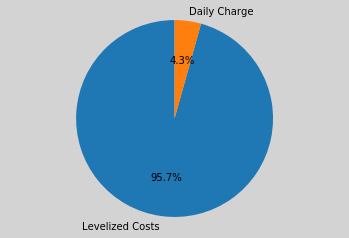

ERROR:ga_logger:panel values: (160.29266527811563, 182.722022535095, 182.53509648374967, 24.546495067357988, 26.91332509265389, 33.02935308549606, 0.6116740898791247, 0.6852275749475252, 0.47736894894841697)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 24.5
                                           and a gcr of 0.612


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2636821269989014 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 26.9
                                           and a gcr of 0.685


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.472276449203491 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 183
                                           a tilt of 33.0
                                           and a gcr of 0.477


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.358748197555542 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 220 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 29.397869193310967, 265.349987515363]


ERROR:ga_logger:Cost: 3060.5511094253593


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


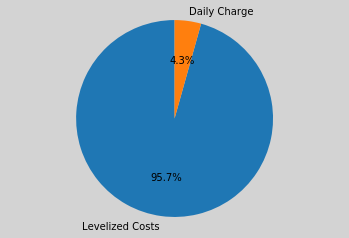

ERROR:ga_logger:panel values: (158.6739591426656, 182.91481279515978, 181.64986049803227, 23.80088964422421, 27.162062710320455, 32.0945350591789, 0.6252865233397544, 0.68916343015261, 0.48883722317051925)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 159
                                           a tilt of 23.8
                                           and a gcr of 0.625


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2461252212524414 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 27.2
                                           and a gcr of 0.689


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2784101963043213 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 182
                                           a tilt of 32.1
                                           and a gcr of 0.489


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3853442668914795 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 217 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [0.0, 5.160927109613128, 289.0362501076344]


ERROR:ga_logger:Cost: 3055.081650291988


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


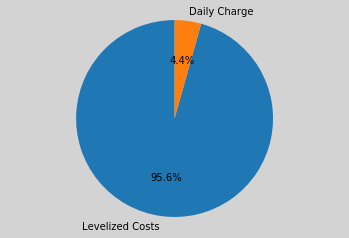

ERROR:ga_logger:panel values: (101.28434314974157, 261.16568101311634, 90.40350232813941, 53.78901692406503, 33.69875800179903, 1.5204878953397878, 0.30727415235663863, 0.88625633360299, 0.8320730851578335)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 101
                                           a tilt of 53.8
                                           and a gcr of 0.307


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.257413625717163 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 261
                                           a tilt of 33.7
                                           and a gcr of 0.886


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3958325386047363 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 1.5
                                           and a gcr of 0.832


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2439968585968018 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 208 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 335.77899986186145]


ERROR:ga_logger:Cost: 3468.080597664348


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


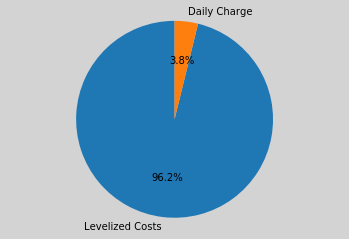

ERROR:ga_logger:panel values: (225.91215714956564, 235.37758010577232, 115.27350669366311, 43.35538955482149, 19.758719618541836, 10.94902148378483, 0.5098406226594354, 0.8940940540460272, 0.8622342178260862)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 226
                                           a tilt of 43.4
                                           and a gcr of 0.510


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.33282208442688 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 19.8
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2879459857940674 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 10.9
                                           and a gcr of 0.862


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.260864496231079 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 168 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 138s


ERROR:ga_logger:panel relevance: [266.8558126711092, 0.0, 64.97057403084013]


ERROR:ga_logger:Cost: 3428.8224785044235


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


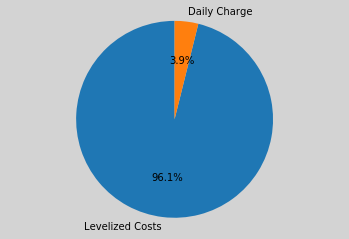

ERROR:ga_logger:panel values: (92.26224983191648, 223.04603440393726, 193.23611372026312, 43.45768918966441, 2.6699623915956776, 3.5842820550608563, 0.8918131880620714, 0.8990383296756554, 0.49399816161312327)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 43.5
                                           and a gcr of 0.892


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2947909832000732 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 223
                                           a tilt of 2.7
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.8206627368927 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 193
                                           a tilt of 3.6
                                           and a gcr of 0.494


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.506075382232666 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 217 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 165s


ERROR:ga_logger:panel relevance: [0.0, 70.80051457860415, 256.8841298122994]


ERROR:ga_logger:Cost: 3387.685843127515


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


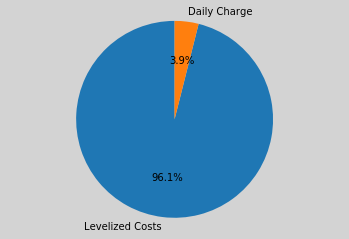

ERROR:ga_logger:panel values: (165.741646361488, 169.31445245758897, 174.30975645467123, 26.482808438997537, 22.482973213285298, 32.24627408499698, 0.6565142237059618, 0.6489555690132554, 0.5028304583709706)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 166
                                           a tilt of 26.5
                                           and a gcr of 0.657


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.583919525146484 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 169
                                           a tilt of 22.5
                                           and a gcr of 0.649


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.288933277130127 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 174
                                           a tilt of 32.2
                                           and a gcr of 0.503


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.295997142791748 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in 112 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 224 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 295.9329996906037]


ERROR:ga_logger:Cost: 3072.322186022862


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


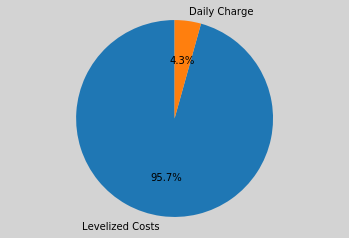

ERROR:ga_logger:panel values: (156.74721406339648, 182.4175188519954, 183.25896779205812, 24.45327819313153, 26.997453604967422, 31.702014890084047, 0.6147611984846757, 0.6992397483802364, 0.4848659860809486)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 24.5
                                           and a gcr of 0.615


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.526895761489868 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 27.0
                                           and a gcr of 0.699


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.506998300552368 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 183
                                           a tilt of 31.7
                                           and a gcr of 0.485


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.445298910140991 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  91 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 222 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 13.918360197653264, 280.667920368896]


ERROR:ga_logger:Cost: 3058.9463020892294


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


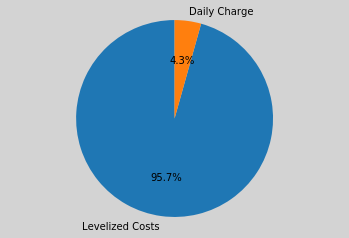

ERROR:ga_logger:panel values: (159.8257987683278, 181.90458417528066, 181.72794065692034, 24.18767481367538, 27.216722754977955, 32.066065587958434, 0.6108687926788796, 0.6800003588981567, 0.4993741101161179)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 24.2
                                           and a gcr of 0.611


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2118899822235107 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 27.2
                                           and a gcr of 0.680


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5553014278411865 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 182
                                           a tilt of 32.1
                                           and a gcr of 0.499


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.348954916000366 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  62 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 219 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 294.35739732996757]


ERROR:ga_logger:Cost: 3056.6729886398607


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


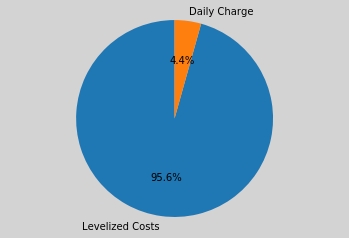

ERROR:ga_logger:panel values: (167.7552795394342, 191.83267119485055, 180.3748463617605, 22.14148873803342, 29.888187647808813, 29.799234879091337, 0.6816554129636241, 0.6646152829605887, 0.49059617250834375)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 168
                                           a tilt of 22.1
                                           and a gcr of 0.682


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.363187789916992 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 29.9
                                           and a gcr of 0.665


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5506908893585205 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 29.8
                                           and a gcr of 0.491


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.426910400390625 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  99 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 221 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.8501601931458367, 293.1226299792439]


ERROR:ga_logger:Cost: 3052.852991573707


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


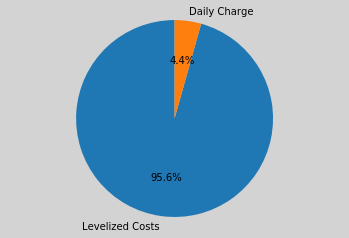

ERROR:ga_logger:panel values: (167.82178490948132, 191.73105856508403, 180.2332928793689, 22.337733276681693, 29.895306250606946, 29.79221979721042, 0.6829553171679873, 0.6664264338579766, 0.4910814299886752)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 168
                                           a tilt of 22.3
                                           and a gcr of 0.683


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.255981683731079 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 29.9
                                           and a gcr of 0.666


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2846925258636475 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 29.8
                                           and a gcr of 0.491


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3239049911499023 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 220 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 293.939365987634]


ERROR:ga_logger:Cost: 3052.52101588928


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


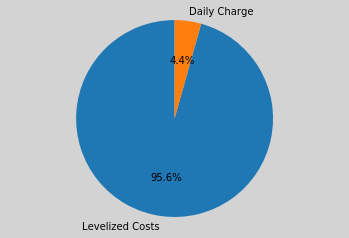

ERROR:ga_logger:panel values: (167.4899513976366, 191.67151578127704, 180.2192889249118, 22.302975593870077, 29.92402987196458, 29.79234554632282, 0.6827623961416489, 0.6659902463166586, 0.4916695141188277)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 22.3
                                           and a gcr of 0.683


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2798781394958496 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 29.9
                                           and a gcr of 0.666


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2909932136535645 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 29.8
                                           and a gcr of 0.492


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.352564573287964 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 218 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 293.951758122826]


ERROR:ga_logger:Cost: 3052.644097062125


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


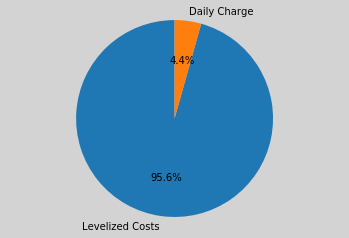

ERROR:ga_logger:panel values: (254.1209037302123, 116.835807275537, 192.2249891220211, 10.145647323720299, 1.3413362974245375, 47.19533971461906, 0.8741950571615942, 0.89575487129926, 0.2943302953163309)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 254
                                           a tilt of 10.1
                                           and a gcr of 0.874


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3109750747680664 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 117
                                           a tilt of 1.3
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2076501846313477 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 192
                                           a tilt of 47.2
                                           and a gcr of 0.294


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3653461933135986 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 214 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [0.0, 217.2045285214724, 104.86387229236335]


ERROR:ga_logger:Cost: 3331.9041988952185


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


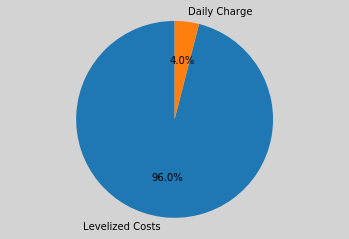

ERROR:ga_logger:panel values: (115.53484871110744, 111.68201663511631, 237.88464608730348, 27.292745150811506, 1.1181500033638812, 43.38067359099355, 0.557276134143408, 0.8783112827138164, 0.5529642471137797)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 116
                                           a tilt of 27.3
                                           and a gcr of 0.557


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2904200553894043 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 112
                                           a tilt of 1.1
                                           and a gcr of 0.878


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.519294500350952 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 238
                                           a tilt of 43.4
                                           and a gcr of 0.553


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.304643154144287 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 212 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [332.74903516408153, 0.0, 0.0]


ERROR:ga_logger:Cost: 3437.9863967496426


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


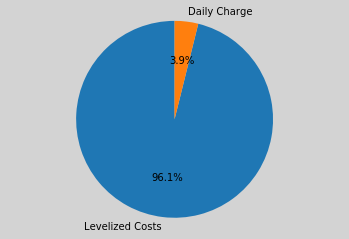

ERROR:ga_logger:panel values: (206.14140956811877, 156.5530264754927, 111.77723043982007, 2.829646178875866, 3.578824830169479, 16.653371144811068, 0.6589976999455799, 0.8964892497013546, 0.7797439760766287)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 206
                                           a tilt of 2.8
                                           and a gcr of 0.659


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.103944778442383 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 157
                                           a tilt of 3.6
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.245241165161133 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 112
                                           a tilt of 16.7
                                           and a gcr of 0.780


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2899279594421387 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 214 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 328.51450186335745, 0.0]


ERROR:ga_logger:Cost: 3395.9281539917483


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


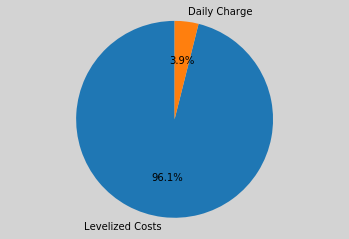

ERROR:ga_logger:panel values: (154.01680877026206, 185.1665774812697, 178.58444112166848, 19.39294325232226, 24.041055936182207, 29.63799876030496, 0.619125352154424, 0.7184848259981502, 0.4830131805945832)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 154
                                           a tilt of 19.4
                                           and a gcr of 0.619


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.244363307952881 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 24.0
                                           and a gcr of 0.718


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.437129497528076 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 179
                                           a tilt of 29.6
                                           and a gcr of 0.483


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.337275505065918 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 216 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 19.08152040363628, 276.38191972868213]


ERROR:ga_logger:Cost: 3067.6584243102216


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


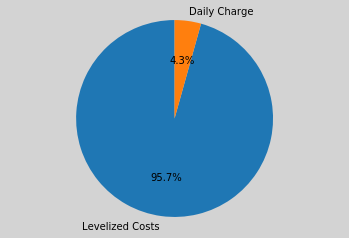

ERROR:ga_logger:panel values: (184.3326060131846, 219.14053849352652, 203.6833985936031, 25.434922988359823, 38.39534916702287, 32.15892156703744, 0.7918551329322578, 0.5581271659663141, 0.37750292703893246)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 184
                                           a tilt of 25.4
                                           and a gcr of 0.792


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.417921781539917 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 219
                                           a tilt of 38.4
                                           and a gcr of 0.558


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2811660766601562 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 204
                                           a tilt of 32.2
                                           and a gcr of 0.378


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.302985906600952 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 194 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [147.46107083624923, 0.0, 155.73483024793921]


ERROR:ga_logger:Cost: 3144.4587723202644


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


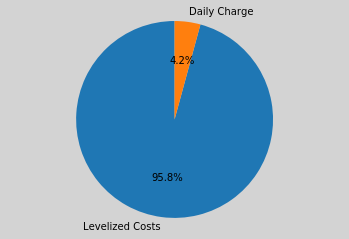

ERROR:ga_logger:panel values: (176.12235402894078, 190.36955335727242, 163.32440649468987, 34.93462036935524, 33.577376736755724, 28.489883974774365, 0.5489492089044736, 0.7868418984849983, 0.29778222156944356)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 176
                                           a tilt of 34.9
                                           and a gcr of 0.549


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.335172414779663 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 33.6
                                           and a gcr of 0.787


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2660839557647705 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 163
                                           a tilt of 28.5
                                           and a gcr of 0.298


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.408778190612793 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 203 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [260.88958194548434, 0.0, 36.77878517328689]


ERROR:ga_logger:Cost: 3089.558204064914


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


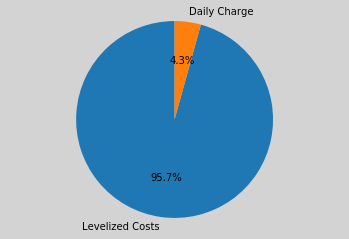

ERROR:ga_logger:panel values: (157.74077877392546, 255.20496031447914, 93.61575166304804, 55.789879659792, 47.38848352411623, 2.284419540147404, 0.8903981557488536, 0.8881379761444748, 0.4253249785381485)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 158
                                           a tilt of 55.8
                                           and a gcr of 0.890


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2712337970733643 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 47.4
                                           and a gcr of 0.888


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3024301528930664 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 94
                                           a tilt of 2.3
                                           and a gcr of 0.425


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1466782093048096 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 207 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [183.63001021989848, 0.0, 166.95200098701858]


ERROR:ga_logger:Cost: 3615.107091514426


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


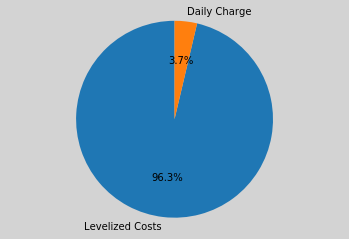

ERROR:ga_logger:panel values: (228.0340340594518, 165.68939684222028, 205.4603166752571, 52.69140142964754, 24.87878882544015, 1.3469175398546471, 0.8869333405295821, 0.8994876542908408, 0.5462016868834454)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 228
                                           a tilt of 52.7
                                           and a gcr of 0.887


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2668251991271973 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 166
                                           a tilt of 24.9
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3577969074249268 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 1.3
                                           and a gcr of 0.546


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9063374996185303 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 214 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 198s


ERROR:ga_logger:panel relevance: [0.0, 323.2809750955012, 0.0]


ERROR:ga_logger:Cost: 3343.947743735067


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


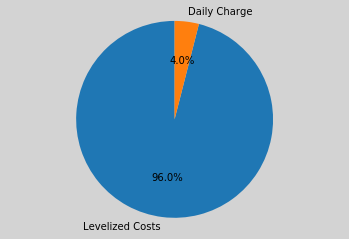

ERROR:ga_logger:panel values: (255.014610738895, 206.02901851513263, 210.00163714097363, 31.679452116778986, 29.01948137894729, 50.11700341130122, 0.8904730693040783, 0.8923061376558628, 0.49815577036040554)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 31.7
                                           and a gcr of 0.890


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5260865688323975 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 206
                                           a tilt of 29.0
                                           and a gcr of 0.892


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.487720489501953 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 50.1
                                           and a gcr of 0.498


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4096274375915527 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  92 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 220 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 59.59923290029143, 265.00358693214076]


ERROR:ga_logger:Cost: 3357.0765903787737


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


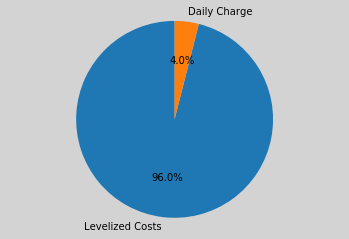

ERROR:ga_logger:panel values: (166.8058093898638, 190.56665181983715, 174.2148417863623, 31.316634152202155, 28.714711255446716, 27.78463552240107, 0.6009612755085718, 0.7724493960364942, 0.4005624060720687)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 31.3
                                           and a gcr of 0.601


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2828269004821777 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 191
                                           a tilt of 28.7
                                           and a gcr of 0.772


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6081387996673584 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 174
                                           a tilt of 27.8
                                           and a gcr of 0.401


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3298869132995605 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 224 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [174.91751211062217, 0.0, 123.25257714993468]


ERROR:ga_logger:Cost: 3094.5414050106606


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


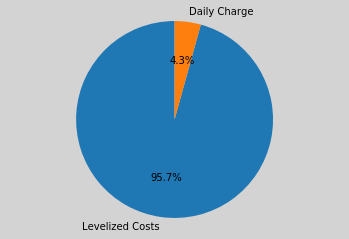

ERROR:ga_logger:panel values: (179.88178857416557, 164.11435456093713, 186.19237801847973, 13.403540898420951, 29.49857122104387, 30.36389798383702, 0.7816870293158475, 0.6212637563655237, 0.4446121231044669)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 13.4
                                           and a gcr of 0.782


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3443806171417236 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 164
                                           a tilt of 29.5
                                           and a gcr of 0.621


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4473116397857666 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 186
                                           a tilt of 30.4
                                           and a gcr of 0.445


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3129422664642334 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  45 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 226 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 108.62037639131212, 188.48170542811022]


ERROR:ga_logger:Cost: 3083.9337416400663


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


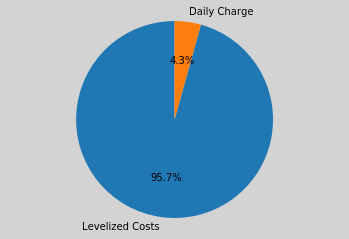

ERROR:ga_logger:panel values: (167.06645562214638, 202.3427267218301, 187.2648842670416, 25.361962470047086, 33.62604444302648, 28.312704053567757, 0.6937320624152534, 0.6653375858115955, 0.4387191654891679)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 25.4
                                           and a gcr of 0.694


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2684311866760254 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 202
                                           a tilt of 33.6
                                           and a gcr of 0.665


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.292916774749756 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 187
                                           a tilt of 28.3
                                           and a gcr of 0.439


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3130879402160645 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 226 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [95.3885458139864, 0.0, 202.3640949521649]


ERROR:ga_logger:Cost: 3090.3952211721016


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


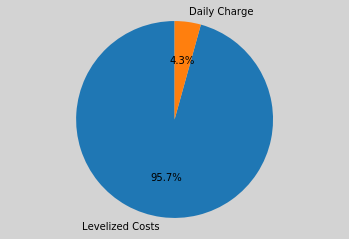

ERROR:ga_logger:panel values: (224.8362812810141, 237.74018265319214, 263.9140174147059, 2.608134257177389, 1.5137223693806658, 8.808808872048015, 0.894528456951055, 0.8750773186808563, 0.4702154812063545)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 2.6
                                           and a gcr of 0.895


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0894675254821777 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 238
                                           a tilt of 1.5
                                           and a gcr of 0.875


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.058521270751953 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 264
                                           a tilt of 8.8
                                           and a gcr of 0.470


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.362121343612671 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 228 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [331.99044655760883, 0.0, 0.0]


ERROR:ga_logger:Cost: 3430.4519300154398


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


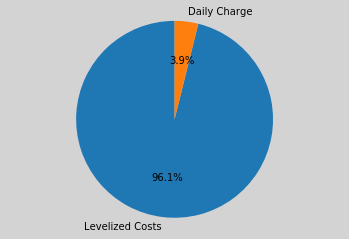

ERROR:ga_logger:panel values: (111.5091319279101, 181.4129237930668, 91.92901147508348, 1.2244337192941708, 4.0680636532589425, 46.81105290898219, 0.896199104406102, 0.8925423248967648, 0.4281367110245904)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 112
                                           a tilt of 1.2
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0517094135284424 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 181
                                           a tilt of 4.1
                                           and a gcr of 0.893


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3163628578186035 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 92
                                           a tilt of 46.8
                                           and a gcr of 0.428


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2760891914367676 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 224 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [0.0, 326.48901156805886, 0.0]


ERROR:ga_logger:Cost: 3375.8105803981866


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


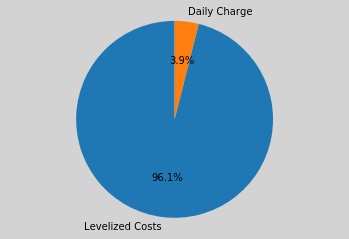

ERROR:ga_logger:panel values: (214.5291240051003, 117.09179560658919, 166.57409868514887, 49.608715010718335, 3.021484187262071, 19.488313911515526, 0.736602087558264, 0.891664951153375, 0.4873655882932786)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 49.6
                                           and a gcr of 0.737


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.235347032546997 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 117
                                           a tilt of 3.0
                                           and a gcr of 0.892


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.29563045501709 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 167
                                           a tilt of 19.5
                                           and a gcr of 0.487


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3392343521118164 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  28 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 225 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 24.196379419636727, 278.5905993194502]


ERROR:ga_logger:Cost: 3140.3972641206105


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


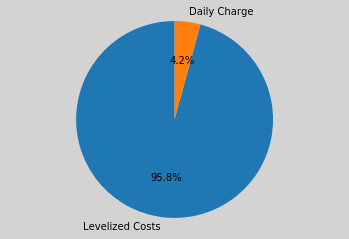

ERROR:ga_logger:panel values: (175.50807018570245, 170.98054763381637, 181.38093532212855, 21.665304024431364, 23.253765560221453, 30.858614995672127, 0.751408936611309, 0.6216702292234196, 0.4532386700031232)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 176
                                           a tilt of 21.7
                                           and a gcr of 0.751


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3207991123199463 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 171
                                           a tilt of 23.3
                                           and a gcr of 0.622


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2862601280212402 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 30.9
                                           and a gcr of 0.453


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.331815242767334 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 226 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 89.33782519267103, 206.24877103404816]


ERROR:ga_logger:Cost: 3068.881634755218


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


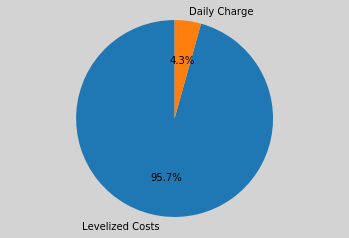

ERROR:ga_logger:panel values: (153.41101924487998, 209.32873542684013, 180.5694173719025, 13.329258716244766, 28.29233672322843, 38.861364703816896, 0.5747938204261152, 0.6974974221969044, 0.37577641026808084)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 153
                                           a tilt of 13.3
                                           and a gcr of 0.575


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2604382038116455 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 209
                                           a tilt of 28.3
                                           and a gcr of 0.697


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.288648843765259 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 38.9
                                           and a gcr of 0.376


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4017608165740967 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 226 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 172.81990533540724, 131.89387191959906]


ERROR:ga_logger:Cost: 3159.5346239468713


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


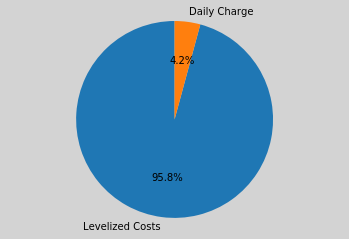

ERROR:ga_logger:panel values: (181.5510223831443, 169.51748530594412, 154.78167390770278, 29.476166373309503, 28.708805585350596, 30.286617872627318, 0.5067673086901305, 0.7638322608005463, 0.3818498243489502)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 182
                                           a tilt of 29.5
                                           and a gcr of 0.507


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.26005482673645 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 28.7
                                           and a gcr of 0.764


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2801668643951416 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 30.3
                                           and a gcr of 0.382


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.322597026824951 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 221 s


In [28]:
# Bonmin path
BONMIN_PATH = "/home/theochri/projects/def-revins/theochri/Bonmin/bonmin"

# GA
if (opt_method =="ga-20"):
    init_pop=20
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="ga-50"):
    init_pop=50
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="ga-100"):
    init_pop=100
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-net"):
    # implementation of the max_evaluations only works starting from 6 or higher
    # also if you set this max_evalutions to 10 it will stop after 9 evaluations
    # therefore I have added 1 to the max_evaluations. 
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE-NET", bonmin_path=BONMIN_PATH, rand_seed =int(run_i+number_of_opt_evaluations)+10 )
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-cost"):
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE", bonmin_path=BONMIN_PATH, rand_seed =int(run_i+number_of_opt_evaluations)+10)
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-cost-true"):
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE", bonmin_path=BONMIN_PATH, rand_seed =int(run_i)+10)
    pvoptimizer.processGA(ga_fina)

